**Expected Dataset Structure After Uploading to Kaggle:**
```
../input/your-dataset-name/
├── TrainSet/
│   ├── X/
│   │   ├── X_000.jpeg
│   │   └── ...
│   └── y/  (NOTE: in the code, 'y' is lowercase)
│       ├── y_000.jpeg
│       └── ...
└── TestSet/  (Will be merged into training if the corresponding y folder exists)
    ├── X/
    │   ├── X_abc.jpeg
    │   └── ...
    └── y/  (Required if you want to merge TestSet into training)
        ├── y_abc.jpeg
        └── ...
```

## Environment Setup and Paths

In [ ]:
# Install required libraries silently
!pip install -q ultralytics opencv-python-headless tqdm

import os
import glob
import shutil
import random
from PIL import Image
import cv2
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
from IPython.display import Image as IPImageDisplay

In [ ]:
# --- PATH CONFIGURATION ---
KAGGLE_DATASET_NAME = 'bank-checks-signatures-segmentation-dataset'

BASE_KAGGLE_INPUT_PATH = f'../input/{KAGGLE_DATASET_NAME}/'

ORIGINAL_TRAIN_IMAGES_DIR = os.path.join(BASE_KAGGLE_INPUT_PATH, 'TrainSet/X')
ORIGINAL_TRAIN_MASKS_DIR = os.path.join(BASE_KAGGLE_INPUT_PATH, 'TrainSet/y')

# Paths for TestSet (images and masks if any for merging into training)
ORIGINAL_TEST_IMAGES_DIR = os.path.join(BASE_KAGGLE_INPUT_PATH, 'TestSet/X')
ORIGINAL_TEST_MASKS_DIR = os.path.join(BASE_KAGGLE_INPUT_PATH, 'TestSet/y')  # Required if merging TestSet into training

# Working directory on Kaggle
BASE_WORKING_DIR = '/kaggle/working/'
YOLO_DATASET_DIR = os.path.join(BASE_WORKING_DIR, 'signature_yolo_dataset')

IMAGES_DIR = os.path.join(YOLO_DATASET_DIR, 'images')
LABELS_DIR = os.path.join(YOLO_DATASET_DIR, 'labels')
TRAIN_IMAGES_PATH = os.path.join(IMAGES_DIR, 'train')
VAL_IMAGES_PATH = os.path.join(IMAGES_DIR, 'val')
TRAIN_LABELS_PATH = os.path.join(LABELS_DIR, 'train')
VAL_LABELS_PATH = os.path.join(LABELS_DIR, 'val')

# Folder to save prediction visualization results (previously named test_set_predictions)
# Since TestSet is merged into train, this folder is used to view predictions on any sample images (could be train/val images)
VISUALIZATION_PREDICTIONS_SAVE_DIR = os.path.join(BASE_WORKING_DIR, 'predictions_visualization')

# Create these directories if they don't exist
for path_dir in [YOLO_DATASET_DIR, IMAGES_DIR, LABELS_DIR,
                 TRAIN_IMAGES_PATH, VAL_IMAGES_PATH,
                 TRAIN_LABELS_PATH, VAL_LABELS_PATH,
                 VISUALIZATION_PREDICTIONS_SAVE_DIR]:
    os.makedirs(path_dir, exist_ok=True)

print(f"Original TrainSet images path: {ORIGINAL_TRAIN_IMAGES_DIR}")
print(f"Original TrainSet masks path: {ORIGINAL_TRAIN_MASKS_DIR}")
print(f"DEBUG: os.path.exists(ORIGINAL_TRAIN_IMAGES_DIR) = {os.path.exists(ORIGINAL_TRAIN_IMAGES_DIR)}")
print(f"DEBUG: os.path.exists(ORIGINAL_TRAIN_MASKS_DIR) = {os.path.exists(ORIGINAL_TRAIN_MASKS_DIR)}")

print(f"Original TestSet images path (for merging/visualizing): {ORIGINAL_TEST_IMAGES_DIR}")
print(f"DEBUG: os.path.exists(ORIGINAL_TEST_IMAGES_DIR) = {os.path.exists(ORIGINAL_TEST_IMAGES_DIR)}")
print(f"Original TestSet masks path (for merging): {ORIGINAL_TEST_MASKS_DIR}")
print(f"DEBUG: os.path.exists(ORIGINAL_TEST_MASKS_DIR) = {os.path.exists(ORIGINAL_TEST_MASKS_DIR)}")

print(f"YOLO dataset folder will be created at: {YOLO_DATASET_DIR}")
print(f"Prediction visualization save folder: {VISUALIZATION_PREDICTIONS_SAVE_DIR}")

# Check existence of basic TrainSet directories
if not os.path.isdir(ORIGINAL_TRAIN_IMAGES_DIR):
    assert False, f"ERROR: TrainSet/X directory not found at: {ORIGINAL_TRAIN_IMAGES_DIR}"
if not os.path.isdir(ORIGINAL_TRAIN_MASKS_DIR):
    assert False, f"ERROR: TrainSet/y directory not found at: {ORIGINAL_TRAIN_MASKS_DIR}"

# Configure merging TestSet into training
MERGE_TEST_SET_INTO_TRAINING = True  # Set to True to merge TestSet, False to use only TrainSet

if MERGE_TEST_SET_INTO_TRAINING:
    print("\n===> MODE: Merging TestSet (images and masks) into training data <===")
    if not os.path.isdir(ORIGINAL_TEST_IMAGES_DIR):
        print(f"WARNING: TestSet/X directory not found at: {ORIGINAL_TEST_IMAGES_DIR}. Cannot merge TestSet.")
        MERGE_TEST_SET_INTO_TRAINING = False
    if not os.path.isdir(ORIGINAL_TEST_MASKS_DIR):
        print(f"WARNING: TestSet/y directory not found at: {ORIGINAL_TEST_MASKS_DIR} (required for masks). Cannot merge TestSet.")
        MERGE_TEST_SET_INTO_TRAINING = False
    if MERGE_TEST_SET_INTO_TRAINING:
        print("TestSet information is valid for merging.")
else:
    print("\n===> MODE: Using only TrainSet for training <===")

## Data Preprocessing 
(Merge TrainSet and TestSet if configured)  
#  
This section will:  
1. Collect image-mask pairs from `TrainSet` and (if requested) from `TestSet`.  
2. Use OpenCV to find bounding boxes from the masks.  
3. Convert bounding box coordinates into YOLO format.  
4. Copy images and create `.txt` label files in the working directory.  
5. Split the merged dataset into training (`train`) and validation (`val`) sets.  


In [ ]:
def convert_mask_to_yolo_format(mask_image_path, original_image_width, original_image_height):
    """
    Convert a mask image file into a list of bounding boxes in YOLO format.
    """
    mask = cv2.imread(mask_image_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"Warning (convert_mask): Could not read mask file: {mask_image_path}")
        return []

    threshold_value = 127  # Threshold for binarizing the mask
    _, thresh = cv2.threshold(mask, threshold_value, 255, cv2.THRESH_BINARY)
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    yolo_annotations = []
    for contour_idx, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area < 50:  # Filter out very small objects (possibly noise) - adjust if needed
            continue
        x_min, y_min, w, h = cv2.boundingRect(contour)
        
        if w == 0 or h == 0:  # Skip invalid bounding boxes
            continue

        # Convert to YOLO format: (class_id x_center y_center width height) - normalized
        x_center = (x_min + w / 2) / original_image_width
        y_center = (y_min + h / 2) / original_image_height
        norm_width = w / original_image_width
        norm_height = h / original_image_height
        
        # Assume only one class 'signature' with class_id = 0
        yolo_annotations.append(f"0 {x_center:.6f} {y_center:.6f} {norm_width:.6f} {norm_height:.6f}")
    return yolo_annotations

def prepare_data_for_yolo(image_mask_pairs_list):
    all_prepared_image_paths = []
    all_prepared_label_paths = []
    # Create temporary directories to store processed images and labels before splitting into train/val
    temp_image_dir = os.path.join(YOLO_DATASET_DIR, "_temp_images_combined") 
    temp_label_dir = os.path.join(YOLO_DATASET_DIR, "_temp_labels_combined")
    os.makedirs(temp_image_dir, exist_ok=True)
    os.makedirs(temp_label_dir, exist_ok=True)

    for img_path, mask_path in tqdm(image_mask_pairs_list, desc="Preparing YOLO data"):
        img_filename_no_ext = os.path.splitext(os.path.basename(img_path))[0]
        
        try:  # Prefer reading with PIL to get dimensions
            with Image.open(img_path) as pil_img:
                img_width, img_height = pil_img.size
        except Exception as e:
            print(f"Warning (prepare_data): Error reading dimensions of {img_path} with PIL: {e}. Trying with OpenCV.")
            cv_img = cv2.imread(img_path)
            if cv_img is not None:
                img_height, img_width = cv_img.shape[:2]  # (height, width, channels)
            else:
                print(f"ERROR (prepare_data): Could not read image {img_path} with either PIL or OpenCV. Skipping.")
                continue
        
        if img_width == 0 or img_height == 0:
            print(f"ERROR (prepare_data): Invalid image dimensions (0) for {img_path}. Skipping.")
            continue

        yolo_annotations = convert_mask_to_yolo_format(mask_path, img_width, img_height)
        
        if yolo_annotations:
            # Copy original image to temporary directory
            dest_image_path = os.path.join(temp_image_dir, os.path.basename(img_path))
            shutil.copy2(img_path, dest_image_path) 
            
            # Create YOLO label file
            label_file_path = os.path.join(temp_label_dir, f"{img_filename_no_ext}.txt")
            with open(label_file_path, 'w') as f:
                for line in yolo_annotations:
                    f.write(line + "\n")
            
            all_prepared_image_paths.append(dest_image_path)
            all_prepared_label_paths.append(label_file_path)
            
    print(f"Processed {len(all_prepared_image_paths)} images with valid annotations.")
    return all_prepared_image_paths, all_prepared_label_paths

# --- Collect image and mask pairs ---
image_mask_pairs = []  # Will contain (image_path, mask_path) pairs

def collect_pairs_from_set(set_name, images_dir, masks_dir, existing_pairs_list):
    """Helper function to collect (image, mask) pairs from a source directory."""
    print(f"\nCollecting data from {set_name}...")
    if not os.path.isdir(images_dir):
        print(f"WARNING: Image directory '{images_dir}' for {set_name} does not exist. Skipping.")
        return
    if not os.path.isdir(masks_dir):
        print(f"WARNING: Mask directory '{masks_dir}' for {set_name} does not exist. Skipping.")
        return

    # Get all .jpeg or .jpg images, case-insensitive for X/x
    # Pattern '[Xx]_*.[jp][pn]g' will match X_*.jpg, X_*.jpeg, x_*.jpg, x_*.jpeg
    image_paths_in_set = glob.glob(os.path.join(images_dir, '[Xx]_*.[jJ][pP][eE][gG]')) + \
                         glob.glob(os.path.join(images_dir, '[Xx]_*.[jJ][pP][gG]'))

    if not image_paths_in_set:
        print(f"No image files found matching pattern '[Xx]_*.(jpeg|jpg)' in {images_dir} for {set_name}.")
        return

    collected_count = 0
    for img_path in tqdm(image_paths_in_set, desc=f"Processing {set_name}"):
        img_filename = os.path.basename(img_path)
        
        # Create corresponding mask filename: y_....ext from X_....ext or x_....ext
        # Keep the original image file extension for the mask (e.g., .jpeg or .jpg)
        img_name_part = img_filename[2:]  # Remove 'X_' or 'x_'
        mask_filename = "y_" + img_name_part
        
        mask_path = os.path.join(masks_dir, mask_filename)

        if os.path.exists(mask_path):
            existing_pairs_list.append((img_path, mask_path))
            collected_count += 1
    print(f"Found {collected_count} valid image-mask pairs in {set_name}.")

# Collect from TrainSet (always performed)
collect_pairs_from_set("TrainSet", ORIGINAL_TRAIN_IMAGES_DIR, ORIGINAL_TRAIN_MASKS_DIR, image_mask_pairs)

# Collect from TestSet (to merge into training) if MERGE_TEST_SET_INTO_TRAINING is True
if MERGE_TEST_SET_INTO_TRAINING:
    collect_pairs_from_set("TestSet (merged into train)", ORIGINAL_TEST_IMAGES_DIR, ORIGINAL_TEST_MASKS_DIR, image_mask_pairs)

print(f"\nTotal of {len(image_mask_pairs)} image-mask pairs (before deduplication).")

# Remove duplicate pairs based on image paths (important if TestSet may overlap with TrainSet)
if image_mask_pairs:
    unique_image_paths_seen = set()
    unique_pairs = []
    for img_p, msk_p in image_mask_pairs:
        if img_p not in unique_image_paths_seen:
            unique_image_paths_seen.add(img_p)
            unique_pairs.append((img_p, msk_p))
    
    if len(unique_pairs) < len(image_mask_pairs):
        print(f"Removed {len(image_mask_pairs) - len(unique_pairs)} duplicate pairs. Unique pairs remaining: {len(unique_pairs)}")
    image_mask_pairs = unique_pairs
    print(f"Number of unique image-mask pairs to process: {len(image_mask_pairs)}")

# Process data (prepare_data_for_yolo will work with merged and filtered image_mask_pairs)
all_images, all_labels = [], []
if image_mask_pairs:
    all_images, all_labels = prepare_data_for_yolo(image_mask_pairs)
else:
    print("ERROR: No image-mask pairs collected. Stopping processing.")
    assert False, "No input data available."

# --- Split train/val from combined data ---
val_images_list = []  # Initialized for use in data.yaml and later checks
train_images_list = []

if all_images and all_labels:
    assert len(all_images) == len(all_labels), "ERROR: Number of images and labels do not match after preparation!"
    
    # Sort to ensure consistency (although train_test_split shuffles)
    all_images.sort()
    all_labels.sort()
    
    val_size_percentage = 0.2  # Validation set percentage (20%)
    
    # Adjust val_size for small datasets
    if len(all_images) < 10: 
        val_size_percentage = 0.1 if len(all_images) > 5 else 0  # No val if <= 5 images total
        if val_size_percentage == 0:
            print("Warning: Too few images (<=5), no separate validation set will be created.")
        
    if val_size_percentage > 0 and len(all_images) * val_size_percentage >= 1:  # Ensure at least 1 val sample
        train_images_list, val_images_list, train_labels_list, val_labels_list = train_test_split(
            all_images, all_labels, test_size=val_size_percentage, random_state=42, shuffle=True
        )
    else:  # Not enough data for validation or val_size_percentage = 0
        train_images_list = all_images
        train_labels_list = all_labels
        val_images_list, val_labels_list = [], []  # No validation set
        print("All data used for training set. No separate validation set.")

    def copy_files_to_final_yolo_dir(source_file_list, destination_folder):
        os.makedirs(destination_folder, exist_ok=True)
        copied_count = 0
        for f_path in tqdm(source_file_list, desc=f"Copying to {os.path.basename(destination_folder)}"):
            try:
                shutil.copy(f_path, os.path.join(destination_folder, os.path.basename(f_path)))
                copied_count += 1
            except Exception as e:
                print(f"Error copying {f_path} to {destination_folder}: {e}")
        print(f"Copied {copied_count} files to {destination_folder}.")

    copy_files_to_final_yolo_dir(train_images_list, TRAIN_IMAGES_PATH)
    copy_files_to_final_yolo_dir(train_labels_list, TRAIN_LABELS_PATH)
    
    if val_images_list:  # Only copy if validation set exists
        copy_files_to_final_yolo_dir(val_images_list, VAL_IMAGES_PATH)
        copy_files_to_final_yolo_dir(val_labels_list, VAL_LABELS_PATH)
        
    print("\nCompleted preparation and splitting of train/val data for YOLO.")
    print(f"Number of training images: {len(os.listdir(TRAIN_IMAGES_PATH))}, Number of training labels: {len(os.listdir(TRAIN_LABELS_PATH))}")
    if val_images_list:
        print(f"Number of validation images: {len(os.listdir(VAL_IMAGES_PATH))}, Number of validation labels: {len(os.listdir(VAL_LABELS_PATH))}")
    else:
        print("No validation set created.")
        
    # Clean up temporary directories after copying
    temp_combined_images = os.path.join(YOLO_DATASET_DIR, "_temp_images_combined")
    temp_combined_labels = os.path.join(YOLO_DATASET_DIR, "_temp_labels_combined")
    if os.path.exists(temp_combined_images):
        shutil.rmtree(temp_combined_images)
        print(f"Deleted temporary directory: {temp_combined_images}")
    if os.path.exists(temp_combined_labels):
        shutil.rmtree(temp_combined_labels)
        print(f"Deleted temporary directory: {temp_combined_labels}")
else:
    print("ERROR: No data prepared (all_images empty). Cannot continue.")
    assert False, "No data available for training."

## Create file `data.yaml`

In [ ]:
# Determine the val path for the yaml file
# If val_images_list is empty (no validation set), point val path to train path
# or better, point to VAL_IMAGES_PATH (which will be an empty directory)
# YOLO typically handles an empty val directory by skipping that validation epoch.
val_path_for_yaml_file = VAL_IMAGES_PATH
if not val_images_list:
    print("Warning: No validation set. In data.yaml, 'val' will point to an empty validation directory or the train directory.")
    # Some YOLO versions may require a valid val path even if empty.
    # Alternatively, if you want YOLO to validate on the train set when no separate val set exists:
    # val_path_for_yaml_file = TRAIN_IMAGES_PATH 
    # However, pointing to VAL_IMAGES_PATH (even if empty) is usually the clearer approach.
    if not os.path.exists(VAL_IMAGES_PATH) or not os.listdir(VAL_IMAGES_PATH):
         print(f"VAL_IMAGES_PATH directory ('{VAL_IMAGES_PATH}') is empty or does not exist. The model will not perform validation epochs.")


yaml_content_str = f"""
train: {TRAIN_IMAGES_PATH}
val: {val_path_for_yaml_file}

# number of classes
nc: 1

# class names
names: ['signature']
"""
yaml_file_path_str = os.path.join(BASE_WORKING_DIR, 'signature_data.yaml')
with open(yaml_file_path_str, 'w') as f:
    f.write(yaml_content_str)
print(f"\nThe signature_data.yaml file has been created at: {yaml_file_path_str}")
print("Content:")
print(yaml_content_str)

## Train YOLO model

In [ ]:
# --- Training Configuration ---
# You can try other YOLOv10 models: yolov10n, yolov10s, yolov10m, yolov10b, yolov10l, yolov10x
CHOSEN_MODEL_NAME = 'yolov10s.pt'  # Smaller model, faster training, suitable for experimentation
NUM_EPOCHS = 100                   # Number of epochs (increase, e.g., 50, 100, 200 for better results on large datasets)
TRAIN_BATCH_SIZE = 16             # Batch size (adjust based on GPU memory, e.g., 8, 16, 32)
INPUT_IMG_SIZE = 640              # Input image size for the model (typically 640 for YOLO)

# Project and run names for organizing results
PROJECT_SAVE_NAME = 'Signature_YOLOv10_Detection_Kaggle'
RUN_SAVE_NAME = f'{os.path.splitext(CHOSEN_MODEL_NAME)[0]}_epochs{NUM_EPOCHS}_batch{TRAIN_BATCH_SIZE}'

# Check the training directory before starting
if not os.path.exists(TRAIN_IMAGES_PATH) or not os.listdir(TRAIN_IMAGES_PATH):
    print(f"ERROR: No images found in training directory: {TRAIN_IMAGES_PATH} or directory does not exist.")
    print("Please check the data preparation steps.")
    assert False, "Training directory is empty or does not exist."

print(f"\nStarting model training: {CHOSEN_MODEL_NAME}")
print(f"Total Epochs: {NUM_EPOCHS}, Batch Size: {TRAIN_BATCH_SIZE}, Image Size: {INPUT_IMG_SIZE}")
print(f"Project will be saved at: {PROJECT_SAVE_NAME}, Run Name: {RUN_SAVE_NAME}")

# Initialize YOLO model (will automatically download pre-trained weights if not present)
yolo_model = YOLO(CHOSEN_MODEL_NAME) 
training_results = None  # Initialize variable to store training results

try:
    training_results = yolo_model.train(
        data=yaml_file_path_str,    # Path to data.yaml file
        epochs=NUM_EPOCHS,
        batch=TRAIN_BATCH_SIZE,
        imgsz=INPUT_IMG_SIZE,
        project=os.path.join(BASE_WORKING_DIR, PROJECT_SAVE_NAME),  # Root directory for saving project
        name=RUN_SAVE_NAME,         # Subdirectory name for this run
        patience=20,                # Early stopping if no improvement after 20 epochs (for val loss)
        exist_ok=True,              # Allow overwriting previous run with same name (useful for debugging)
        # workers=2,                # Number of data loading threads, adjust if needed
        # device=0,                 # Specify GPU (0) or CPU ('cpu')
        # val=True,                 # Default is True, will run validation after each epoch if val set exists
    )
    print("\n🎉 Training completed!")
    if training_results:
        print(f"Results and model saved at: {training_results.save_dir}")  # training_results.save_dir is the exact path

    # Evaluate model on validation set if it exists and training was successful
    if val_images_list and training_results:  # Only evaluate if validation set exists and training was successful
        print("\nEvaluating model on validation set...")
        # Path to the best model after training
        best_trained_model_path = os.path.join(training_results.save_dir, 'weights/best.pt')
        if os.path.exists(best_trained_model_path):
            final_trained_model = YOLO(best_trained_model_path)
            validation_metrics = final_trained_model.val()  # Will use val path from data.yaml by default
            print("Evaluation on validation set completed.")
            # Print key metrics, for example:
            print(f"  mAP50-95: {validation_metrics.box.map:.4f}")
            print(f"  mAP50:    {validation_metrics.box.map50:.4f}")
            # print(f"  mAP75:    {validation_metrics.box.map75:.4f}")
        else:
            print(f"ERROR: Best model not found at '{best_trained_model_path}' for evaluation.")
    elif not val_images_list:
        print("\nNote: No separate validation set available for automatic evaluation after training.")
        
except Exception as e:
    print(f"A serious error occurred during training: {e}")
    import traceback
    traceback.print_exc()


Bắt đầu huấn luyện model: yolov10l.pt
Tổng số Epochs: 100, Kích thước Batch: 16, Kích thước ảnh: 640
Project sẽ được lưu tại: Signature_YOLOv10_Detection_Kaggle, Tên lần chạy: yolov10l_epochs100_batch16


100%|██████████| 50.0M/50.0M [00:00<00:00, 130MB/s] 


Ultralytics 8.3.144 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/signature_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov10l_epochs100_batch16, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspectiv

train: Scanning /kaggle/working/signature_yolo_dataset/labels/train.cache... 126 images, 0 backgrounds, 0 corrupt: 100%|██████████| 126/126 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.1±0.1 ms, read: 905.5±1010.9 MB/s, size: 688.4 KB)


val: Scanning /kaggle/working/signature_yolo_dataset/labels/val.cache... 32 images, 0 backgrounds, 0 corrupt: 100%|██████████| 32/32 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/Signature_YOLOv10_Detection_Kaggle/yolov10l_epochs100_batch16/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 167 weight(decay=0.0), 180 weight(decay=0.0005), 179 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/Signature_YOLOv10_Detection_Kaggle/yolov10l_epochs100_batch16
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      15.5G      4.243      14.64      2.922         53        640: 100%|██████████| 8/8 [00:08<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all         32         77     0.0211     0.0519    0.00627    0.00115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      12.3G      4.092      13.07      2.653         74        640: 100%|██████████| 8/8 [00:08<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         32         77      0.236      0.247      0.128     0.0712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      12.4G      3.736      8.428      2.657         60        640: 100%|██████████| 8/8 [00:08<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         32         77          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      12.5G      3.662      6.135      2.739         66        640: 100%|██████████| 8/8 [00:08<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all         32         77    0.00219      0.221    0.00187   0.000462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      12.6G      3.516      5.281      2.748         46        640: 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all         32         77          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      12.5G       4.08       5.06      2.964         85        640: 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         32         77          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      12.5G      4.181      4.221      3.054         67        640: 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all         32         77          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      12.5G      4.047      4.107       2.92         45        640: 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         32         77          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      12.5G      4.114       3.88      2.943         61        640: 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all         32         77          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      12.4G       4.12      3.943      2.914         73        640: 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         32         77   0.000365      0.013   0.000171   1.71e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      12.5G      4.181      3.847      3.013         71        640: 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

                   all         32         77   0.000414      0.026   0.000222   6.08e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      12.4G      4.162      3.681      2.973         49        640: 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all         32         77    0.00679      0.026    0.00175    0.00028



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      12.4G       4.14      3.883      3.033         69        640: 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all         32         77   0.000429     0.0519   0.000221   4.35e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      12.4G       3.93      3.366      2.905         57        640: 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

                   all         32         77          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      12.4G      3.996      3.662      2.968         54        640: 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         32         77   0.000313      0.039   0.000164   3.77e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      12.4G      4.095      3.719        2.9         80        640: 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

                   all         32         77   0.000488      0.013   0.000288   3.99e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      12.4G      3.953      3.367      2.823         54        640: 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

                   all         32         77    0.00206      0.026   0.000185   3.54e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      12.4G      3.773      3.292      2.779         70        640: 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

                   all         32         77          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      12.4G      3.726      3.161      2.736         92        640: 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

                   all         32         77   0.000177      0.013   0.000176   7.05e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      12.4G      3.779      3.243      2.792         47        640: 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

                   all         32         77   0.000313      0.039    0.00024   5.75e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      12.5G      3.881      3.212      2.826         76        640: 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         32         77     0.0455     0.0649     0.0215    0.00656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      12.5G       3.72      3.136      2.703         66        640: 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         32         77      0.147      0.182     0.0678     0.0229
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 2, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



22 epochs completed in 0.063 hours.
Optimizer stripped from /kaggle/working/Signature_YOLOv10_Detection_Kaggle/yolov10l_epochs100_batch16/weights/last.pt, 52.1MB
Optimizer stripped from /kaggle/working/Signature_YOLOv10_Detection_Kaggle/yolov10l_epochs100_batch16/weights/best.pt, 52.1MB

Validating /kaggle/working/Signature_YOLOv10_Detection_Kaggle/yolov10l_epochs100_batch16/weights/best.pt...
Ultralytics 8.3.144 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv10l summary (fused): 174 layers, 24,310,099 parameters, 0 gradients, 120.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


                   all         32         77      0.232      0.247      0.128     0.0712


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 9.4ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to /kaggle/working/Signature_YOLOv10_Detection_Kaggle/yolov10l_epochs100_batch16

🎉 Hoàn thành huấn luyện!
Kết quả và model đã được lưu tại: /kaggle/working/Signature_YOLOv10_Detection_Kaggle/yolov10l_epochs100_batch16

Đang đánh giá model trên tập validation...
Ultralytics 8.3.144 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv10l summary (fused): 174 layers, 24,310,099 parameters, 0 gradients, 120.0 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3156.5±1465.7 MB/s, size: 708.5 KB)


val: Scanning /kaggle/working/signature_yolo_dataset/labels/val.cache... 32 images, 0 backgrounds, 0 corrupt: 100%|██████████| 32/32 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


                   all         32         77      0.248      0.273      0.154     0.0848


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 2.9ms preprocess, 13.3ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/val2
Đánh giá trên tập validation hoàn tất.
  mAP50-95: 0.0848
  mAP50:    0.1535


## View Training Results
#
-   Training results (including model weights, charts, etc.) will be located in the directory:
    `/kaggle/working/PROJECT_SAVE_NAME/RUN_SAVE_NAME/`
-   You can download these files from the "Output" section of the Kaggle Notebook after committing.

Thư mục kết quả huấn luyện: /kaggle/working/Signature_YOLOv10_Detection_Kaggle/yolov10l_epochs100_batch16

Biểu đồ tổng hợp quá trình huấn luyện (results.png):


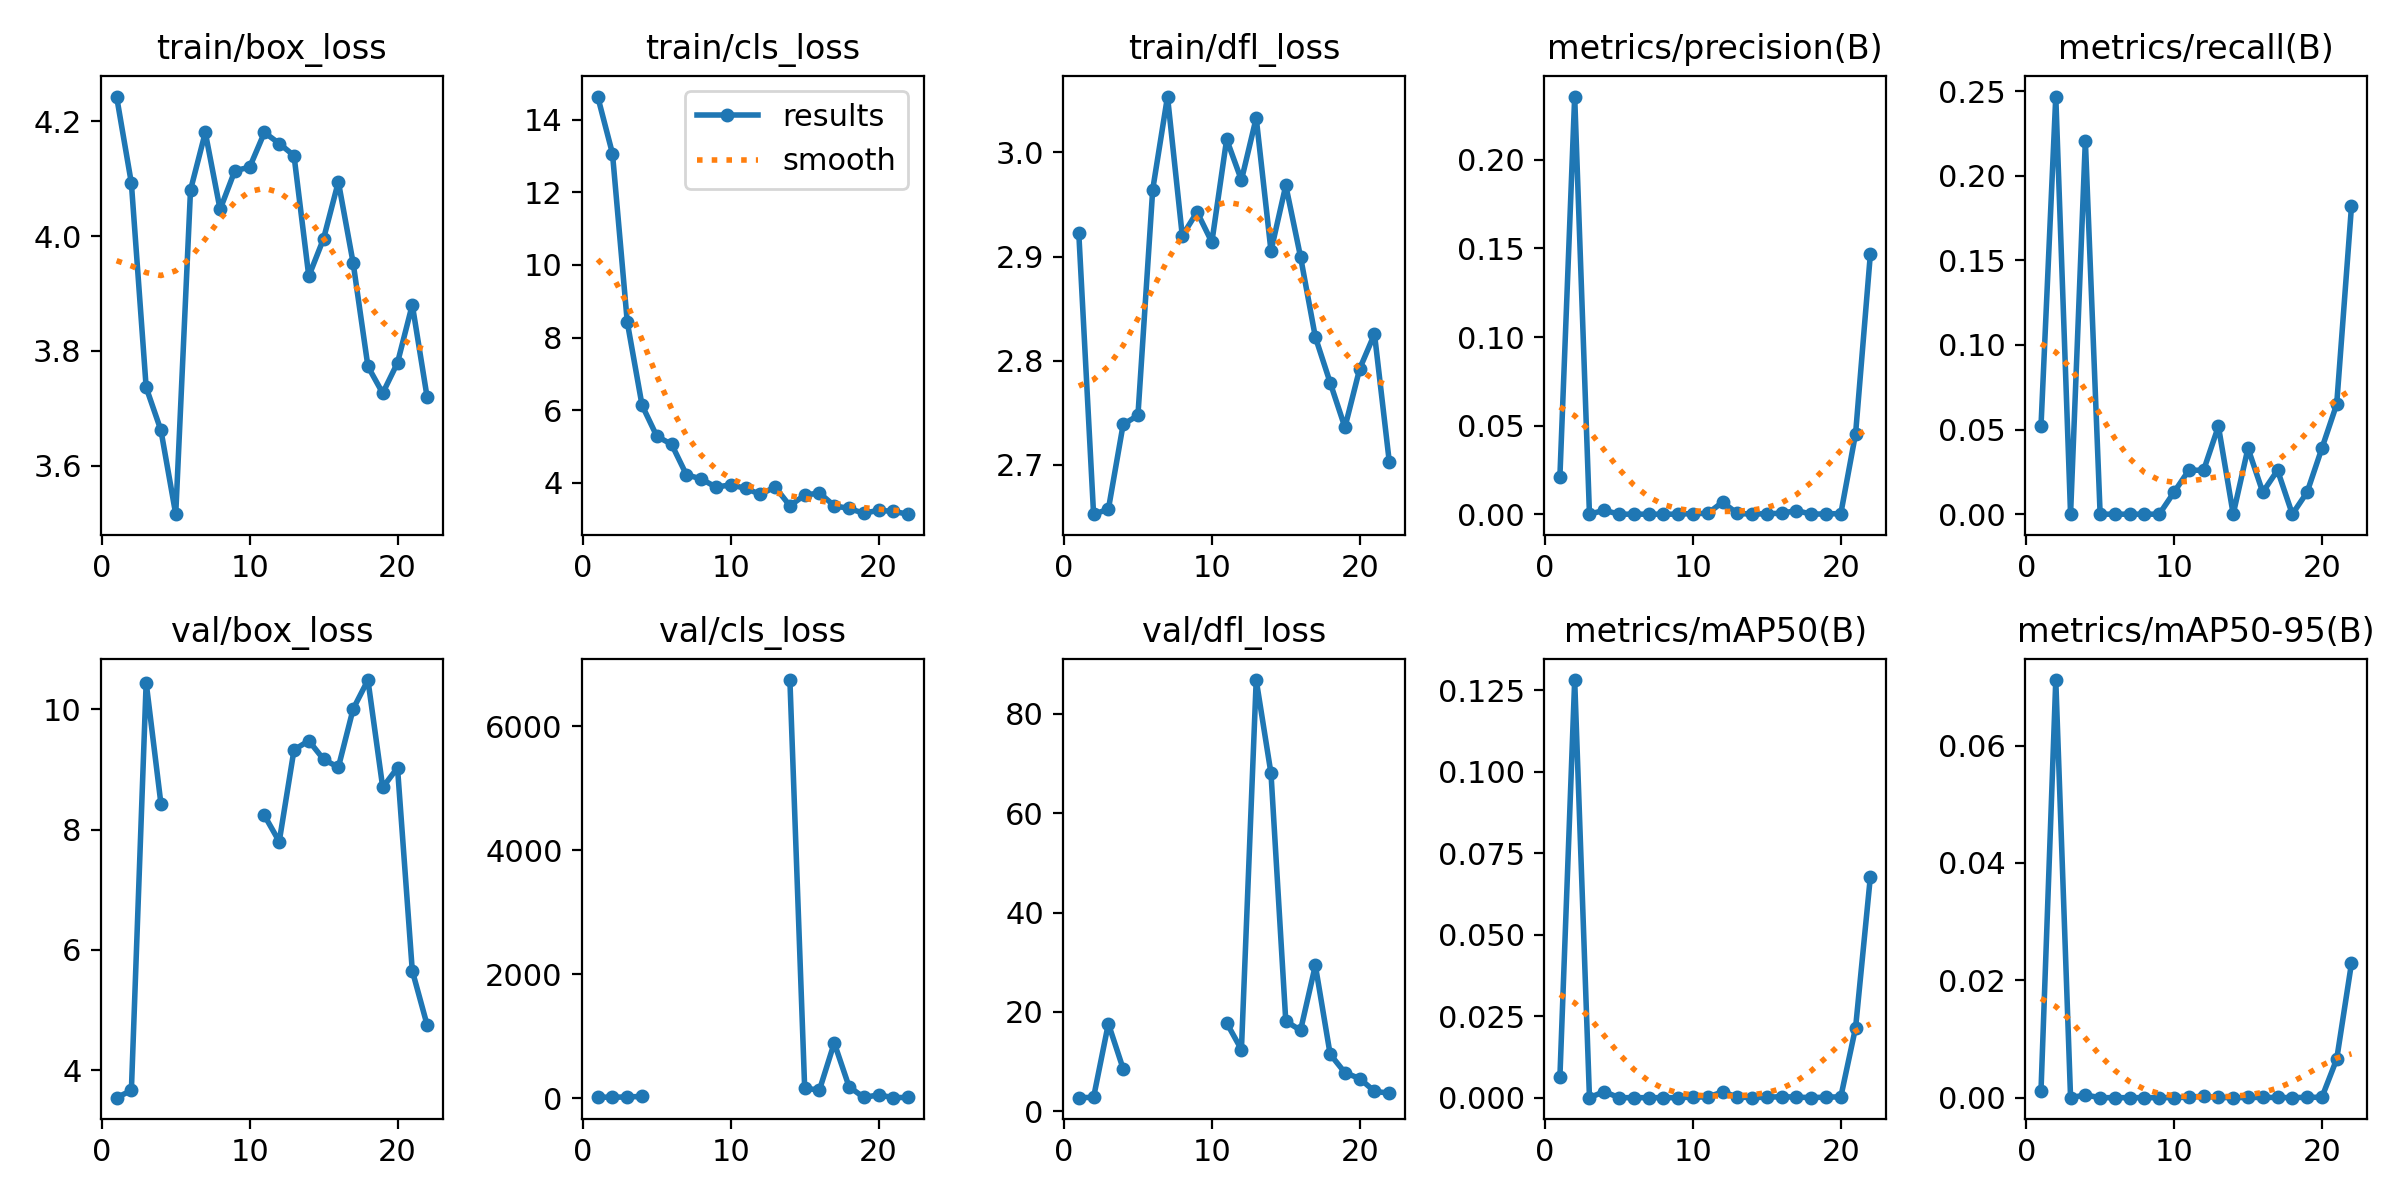


Hình ảnh dự đoán trên một batch của tập validation (val_batch0_pred.jpg):


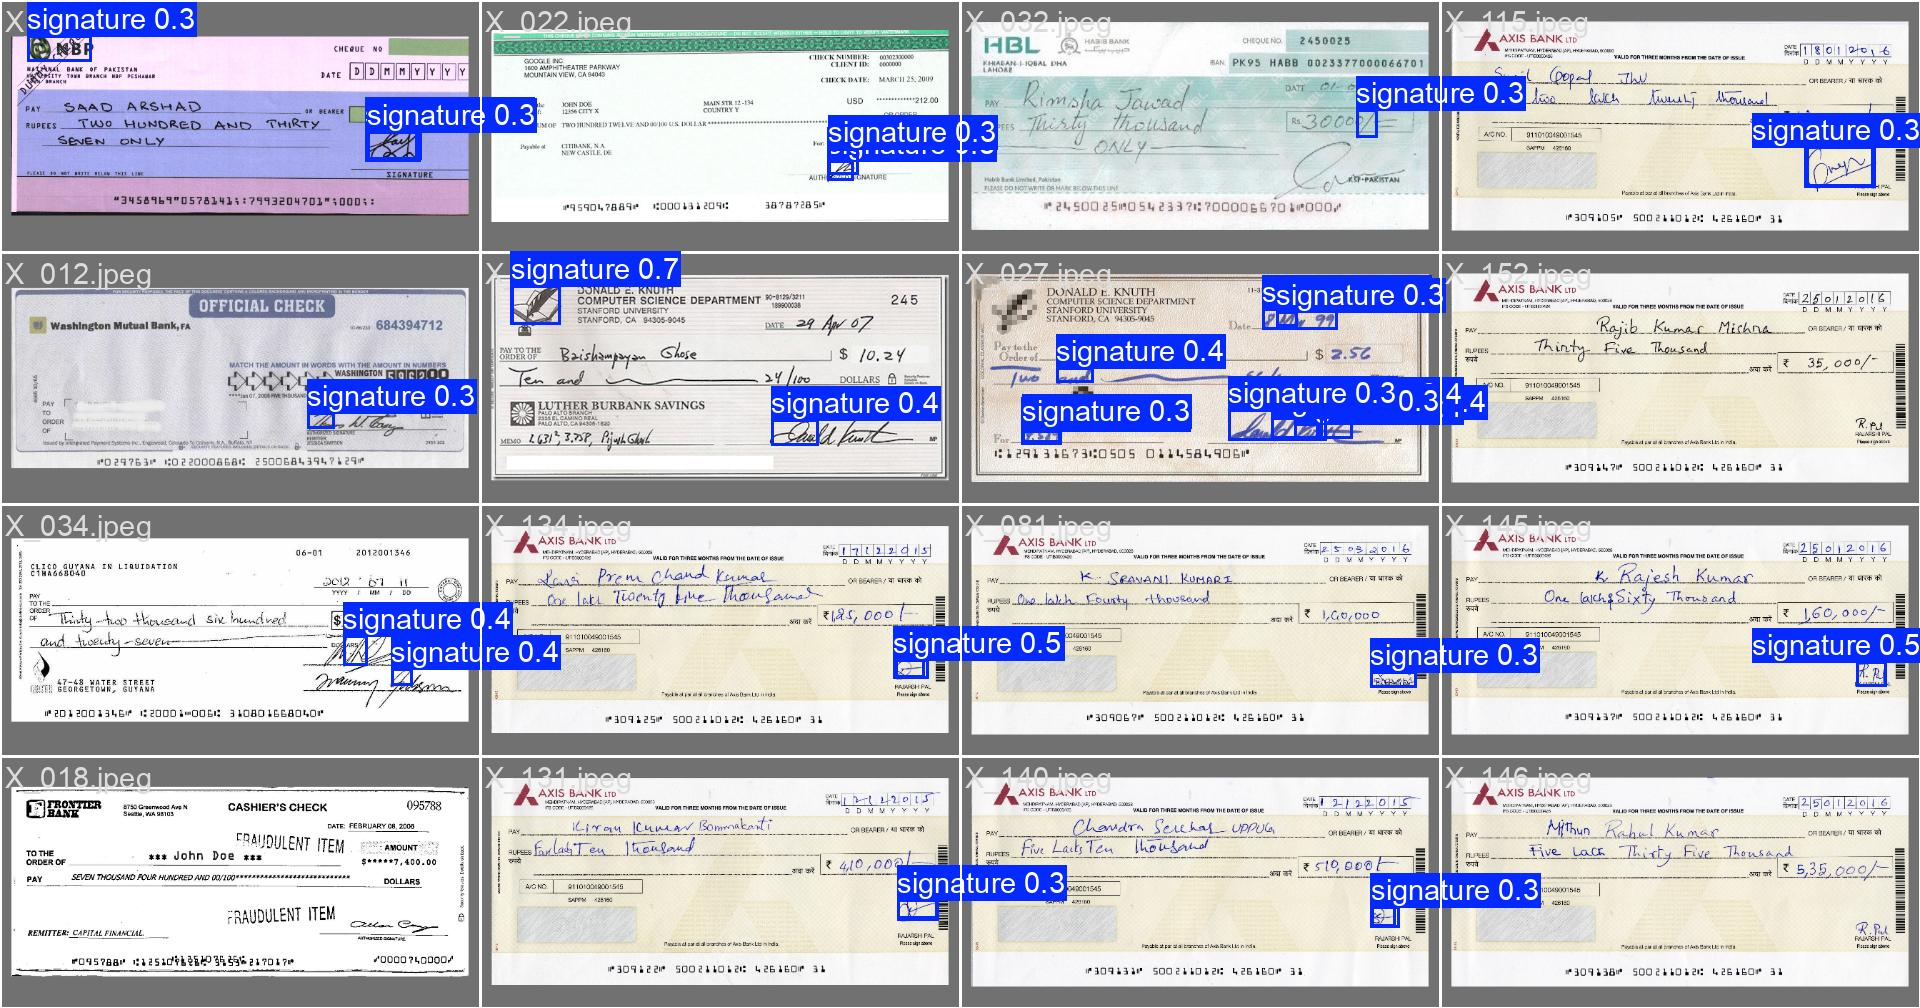


Ma trận nhầm lẫn (Confusion Matrix) trên tập validation:


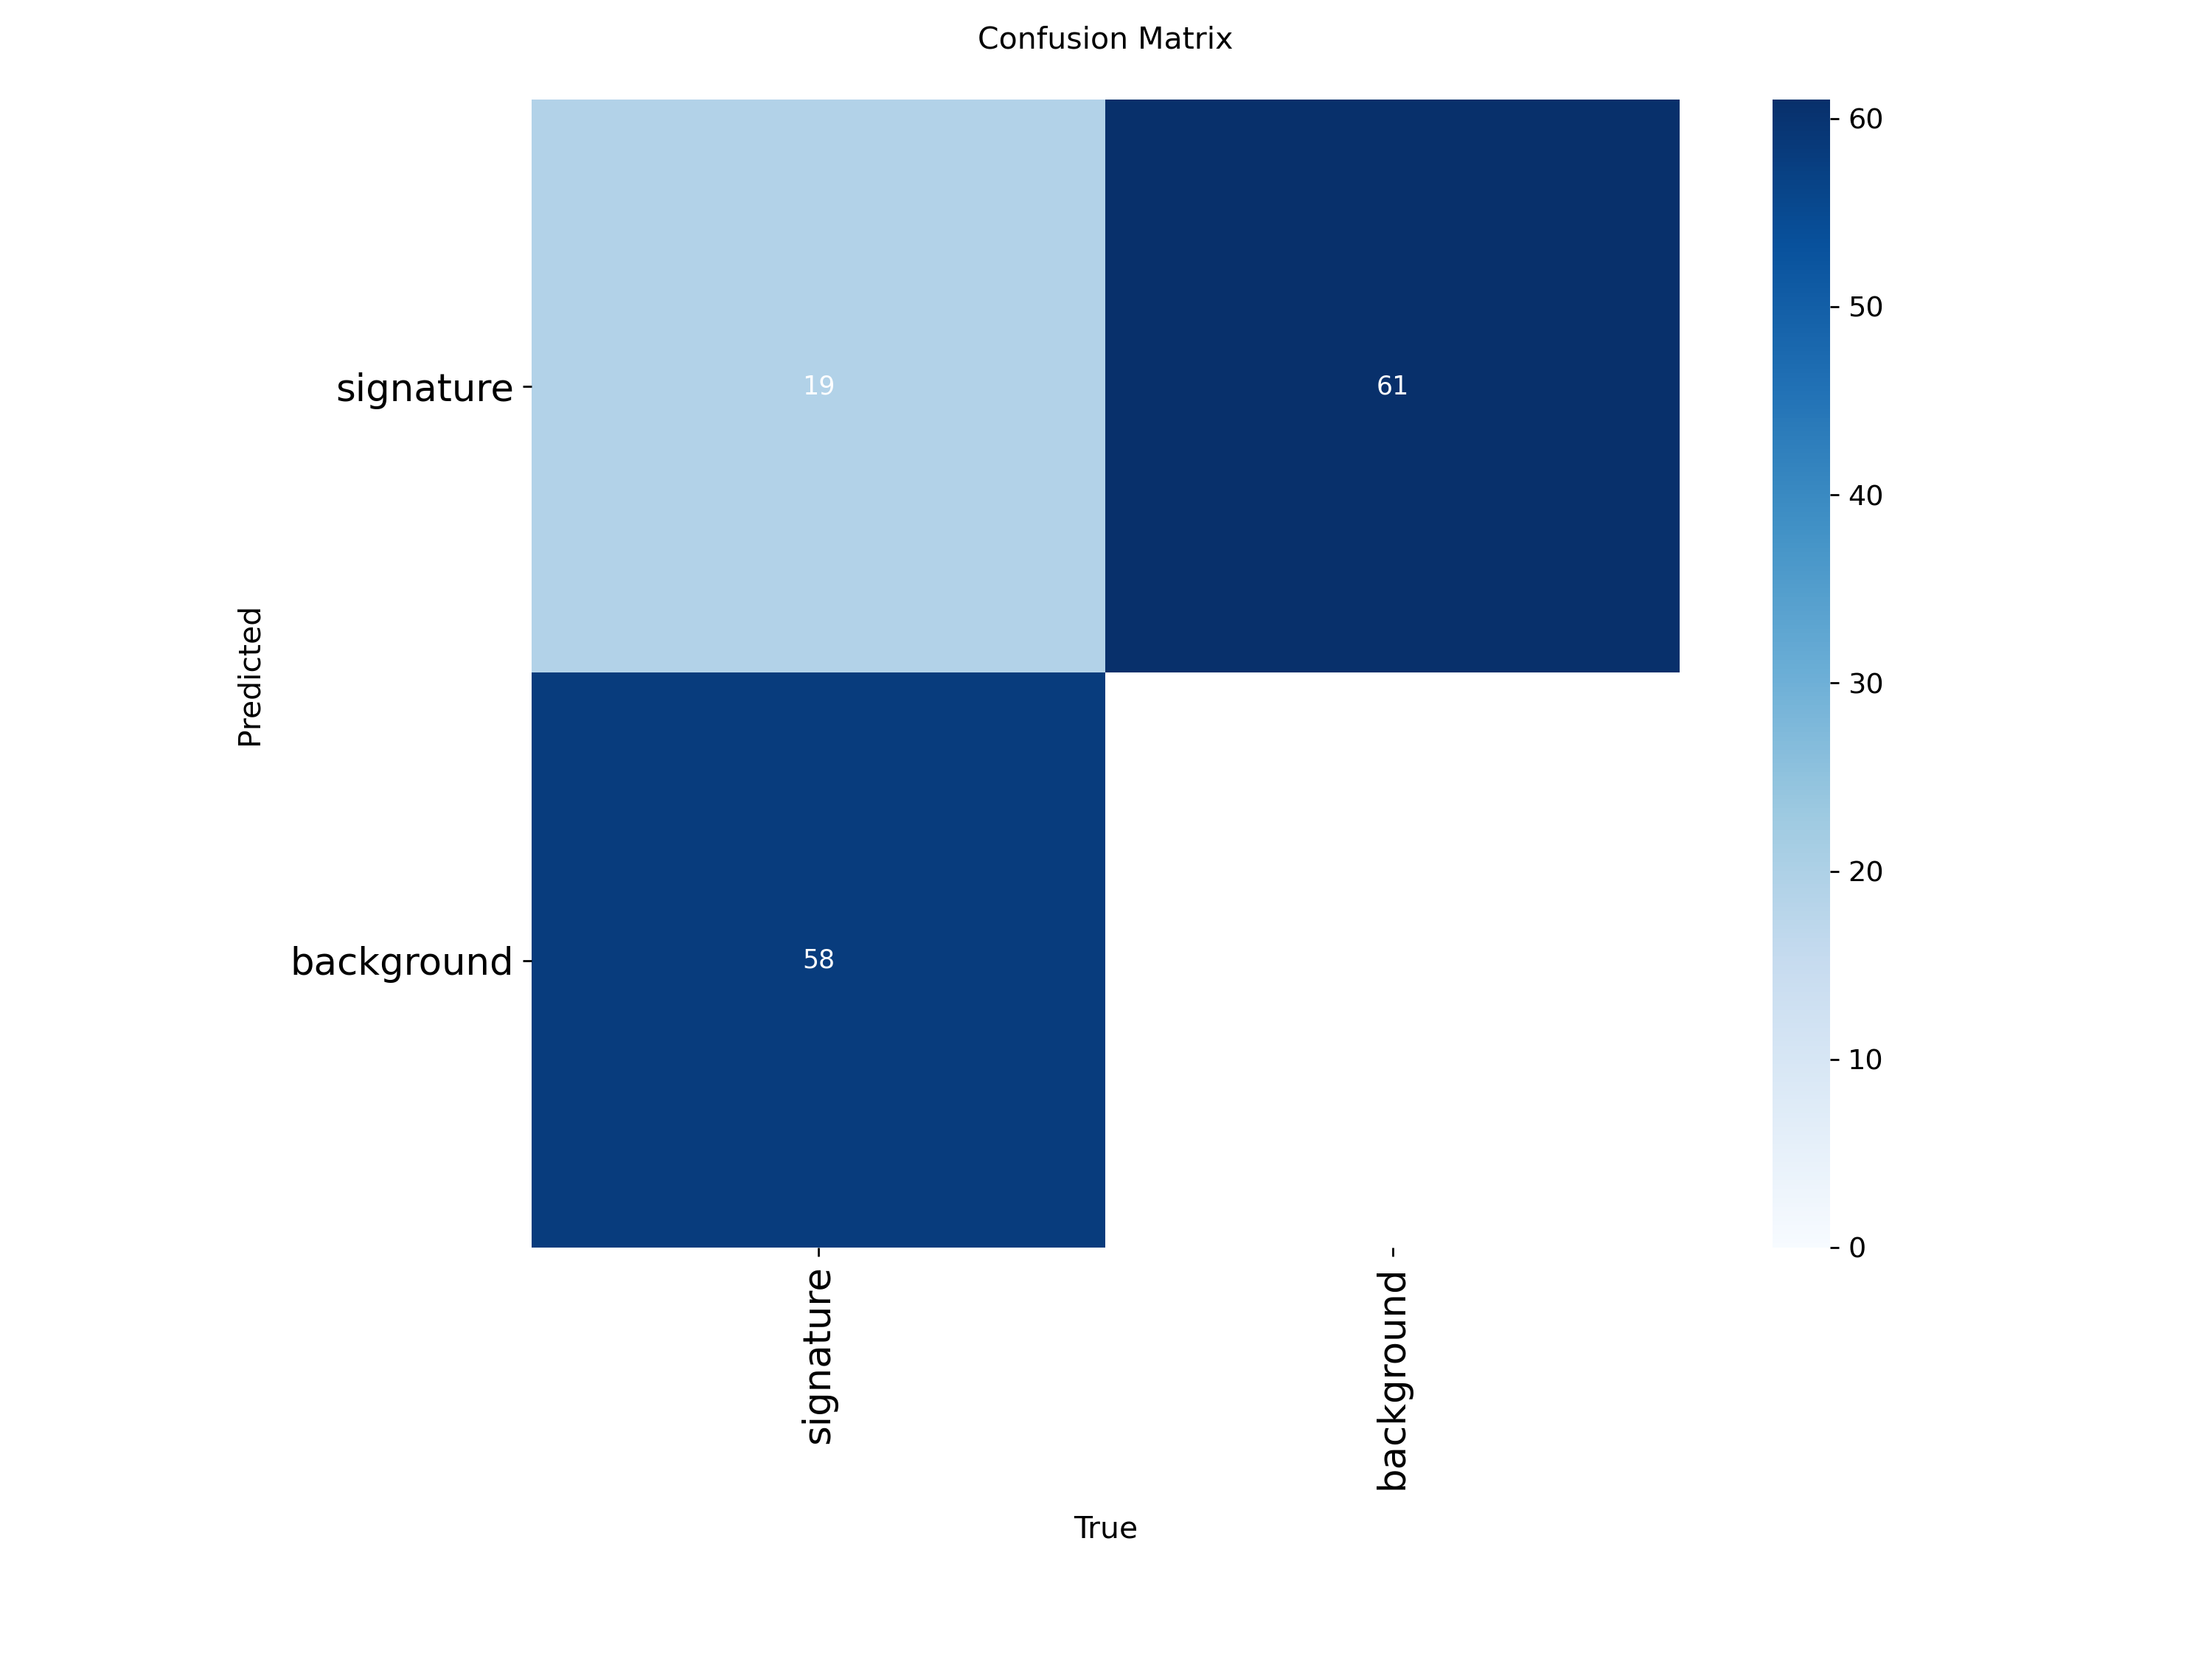

In [ ]:
# Display training result charts if training has been run and results are available
# Ensure PROJECT_SAVE_NAME and RUN_SAVE_NAME are defined from the training cell
if 'PROJECT_SAVE_NAME' in locals() and 'RUN_SAVE_NAME' in locals() and 'BASE_WORKING_DIR' in locals():
    # Try to get the path from training_results if available, otherwise construct manually
    if 'training_results' in locals() and training_results and hasattr(training_results, 'save_dir'):
        run_specific_output_path = training_results.save_dir
    else:  # Construct manually if training_results is unavailable (e.g., due to partial failure)
        run_specific_output_path = os.path.join(BASE_WORKING_DIR, PROJECT_SAVE_NAME, RUN_SAVE_NAME)

    if os.path.exists(run_specific_output_path):
        print(f"Training results directory: {run_specific_output_path}")
        
        # Display results.png chart (contains loss curves, mAP curves, etc.)
        results_plot_png_path = os.path.join(run_specific_output_path, 'results.png')
        if os.path.exists(results_plot_png_path):
            print("\nTraining summary chart (results.png):")
            display(IPImageDisplay(filename=results_plot_png_path, width=900))  # Increase width for better visibility
        else:
            print("\n'results.png' file not found in the results directory.")

        # Display prediction images on a batch from the validation set (if val set exists)
        if val_images_list:  # Check if there is a validation set
            val_batch_prediction_image_path = os.path.join(run_specific_output_path, 'val_batch0_pred.jpg')
            if os.path.exists(val_batch_prediction_image_path):
                print("\nPrediction images on a batch from the validation set (val_batch0_pred.jpg):")
                display(IPImageDisplay(filename=val_batch_prediction_image_path, width=900))
            # else:
                # print("\n'val_batch0_pred.jpg' not found. This may be due to no validation set or an error during saving.")
        
        # Or display an image from a training batch if no validation batch image is available
        else:  # If there is no val_images_list (i.e., no validation set)
            train_batch_image_path = os.path.join(run_specific_output_path, 'train_batch0.jpg')
            if os.path.exists(train_batch_image_path):
                print("\nImage from a training batch (train_batch0.jpg):")
                display(IPImageDisplay(filename=train_batch_image_path, width=900))
            # else:
            #     print("\nNo sample batch image from training ('train_batch0.jpg') found.")
        
        # Confusion matrix (if available)
        confusion_matrix_path = os.path.join(run_specific_output_path, 'confusion_matrix.png')
        if os.path.exists(confusion_matrix_path):
            print("\nConfusion Matrix on the validation set:")
            display(IPImageDisplay(filename=confusion_matrix_path, width=700))

    else:  # If run_specific_output_path does not exist
        print(f"Results directory '{run_specific_output_path}' does not exist.")
        print("This may occur if training has not been performed, failed midway, or project/run names were changed.")
else:
    print("PROJECT_SAVE_NAME or RUN_SAVE_NAME variables are not defined from the training cell. Cannot display results.")

## Visualize Predictions on Some Images (Optional) 
#
**IMPORTANT NOTE:**
If you have merged `TestSet/X` and `TestSet/y` into the training data (via the flag `MERGE_TEST_SET_INTO_TRAINING = True`),
then `ORIGINAL_TEST_IMAGES_DIR` (if used below as the image source) will contain images **ALREADY USED IN TRAINING**.
Predicting on these images is not a true "test" on unseen data.
#
This section is primarily for visually inspecting the model's results on specific images (which could be from the train set, validation set, or a completely new set if you provide a different path).
The results (images with drawn bounding boxes) will be saved to the configured directory (`VISUALIZATION_PREDICTIONS_SAVE_DIR`).

Sử dụng model 'best.pt' từ lần huấn luyện hiện tại cho trực quan hóa: /kaggle/working/Signature_YOLOv10_Detection_Kaggle/yolov10l_epochs100_batch16/weights/best.pt
Lấy ảnh mẫu từ tập validation (/kaggle/working/signature_yolo_dataset/images/val) để trực quan hóa.

Bắt đầu trực quan hóa dự đoán trên 5 ảnh mẫu...

0: 640x640 (no detections), 18.6ms
1: 640x640 (no detections), 18.6ms
2: 640x640 4 signatures, 18.6ms
3: 640x640 2 signatures, 18.6ms
4: 640x640 1 signature, 18.6ms
Speed: 2.1ms preprocess, 18.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /kaggle/working/predictions_visualization/yolov10l_viz_predictions
Đã hoàn thành trực quan hóa. Kết quả (ảnh kèm bounding box) được lưu tại: /kaggle/working/predictions_visualization/yolov10l_viz_predictions

Hiển thị các ảnh đã được trực quan hóa (5 ảnh):
Ảnh dự đoán: /kaggle/working/predictions_visualization/yolov10l_viz_predictions/X_027.jpg


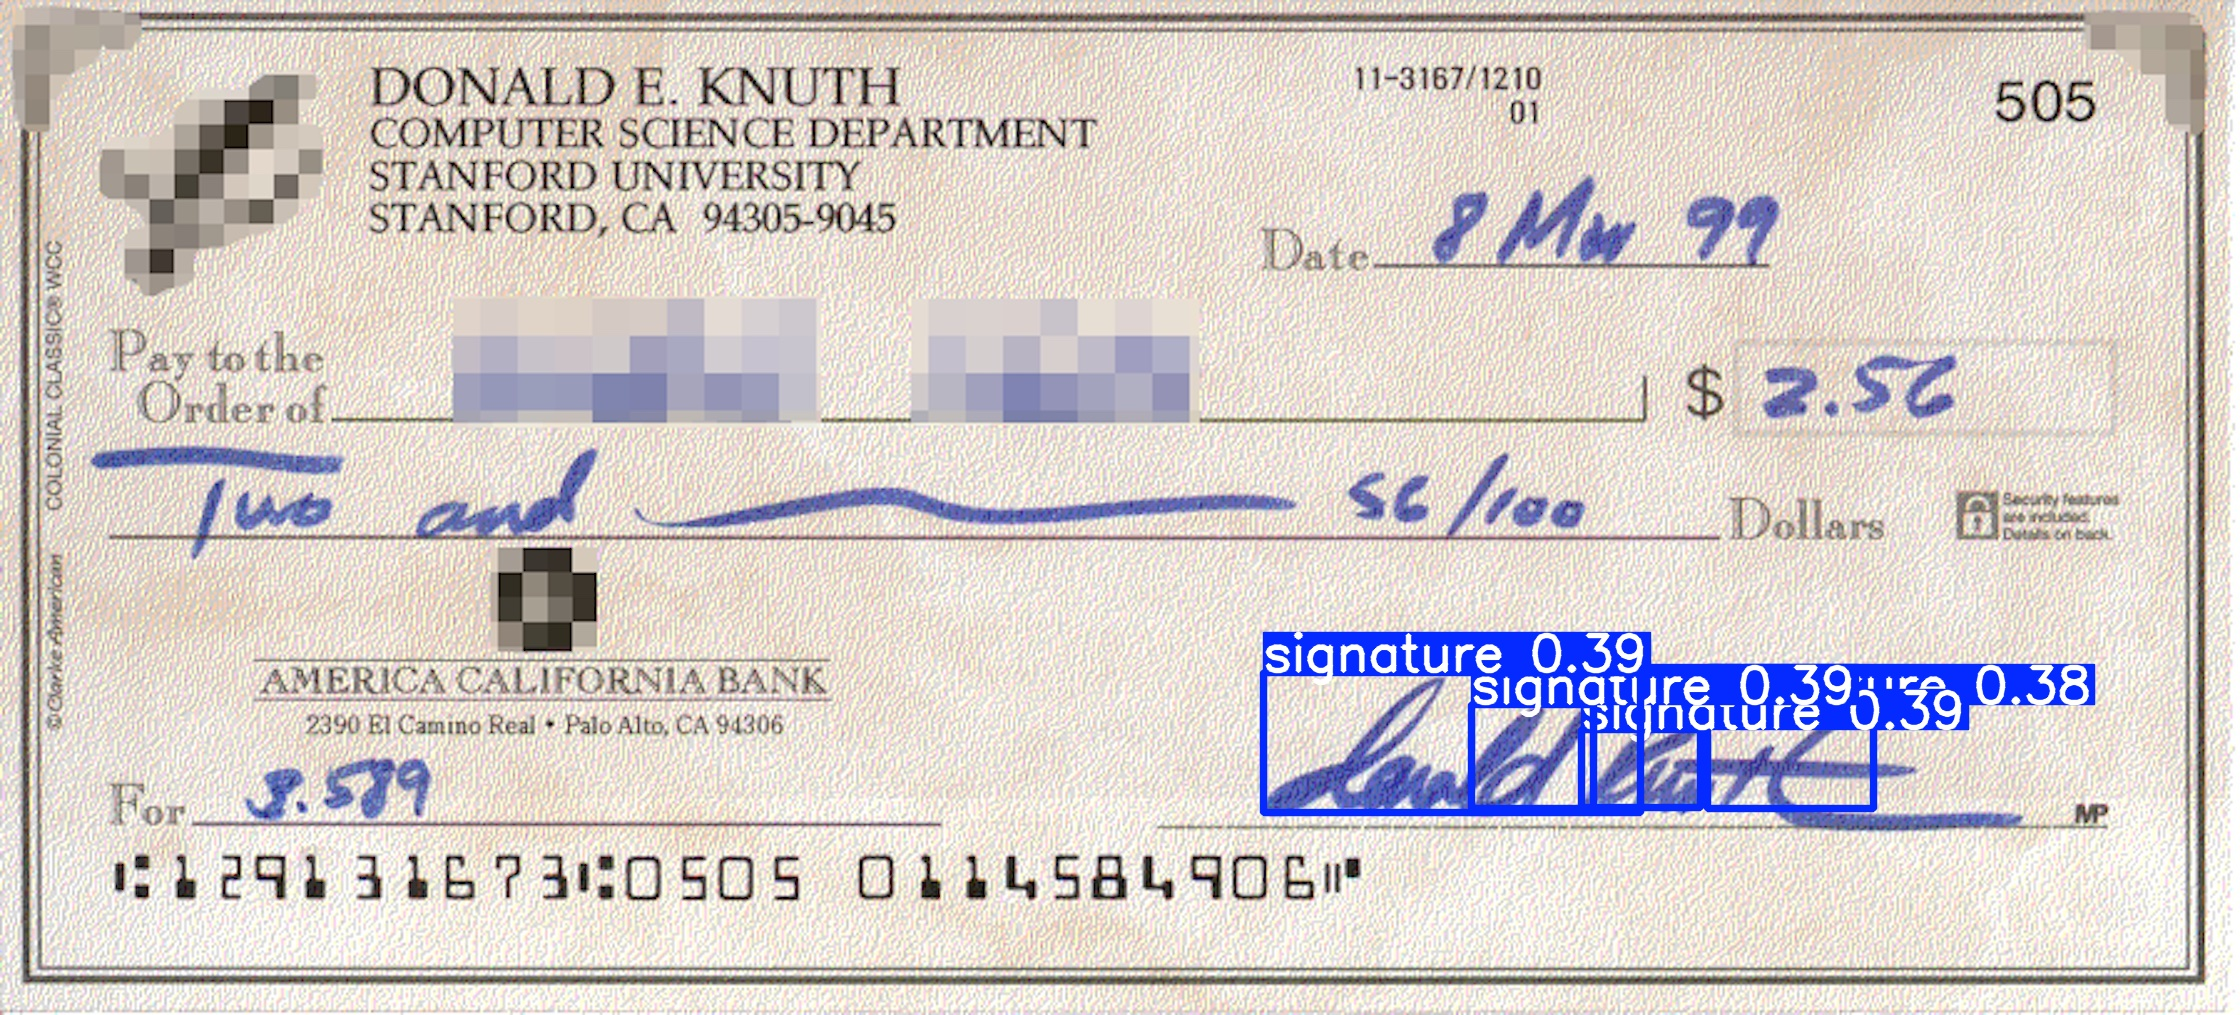

Ảnh dự đoán: /kaggle/working/predictions_visualization/yolov10l_viz_predictions/X_032.jpg


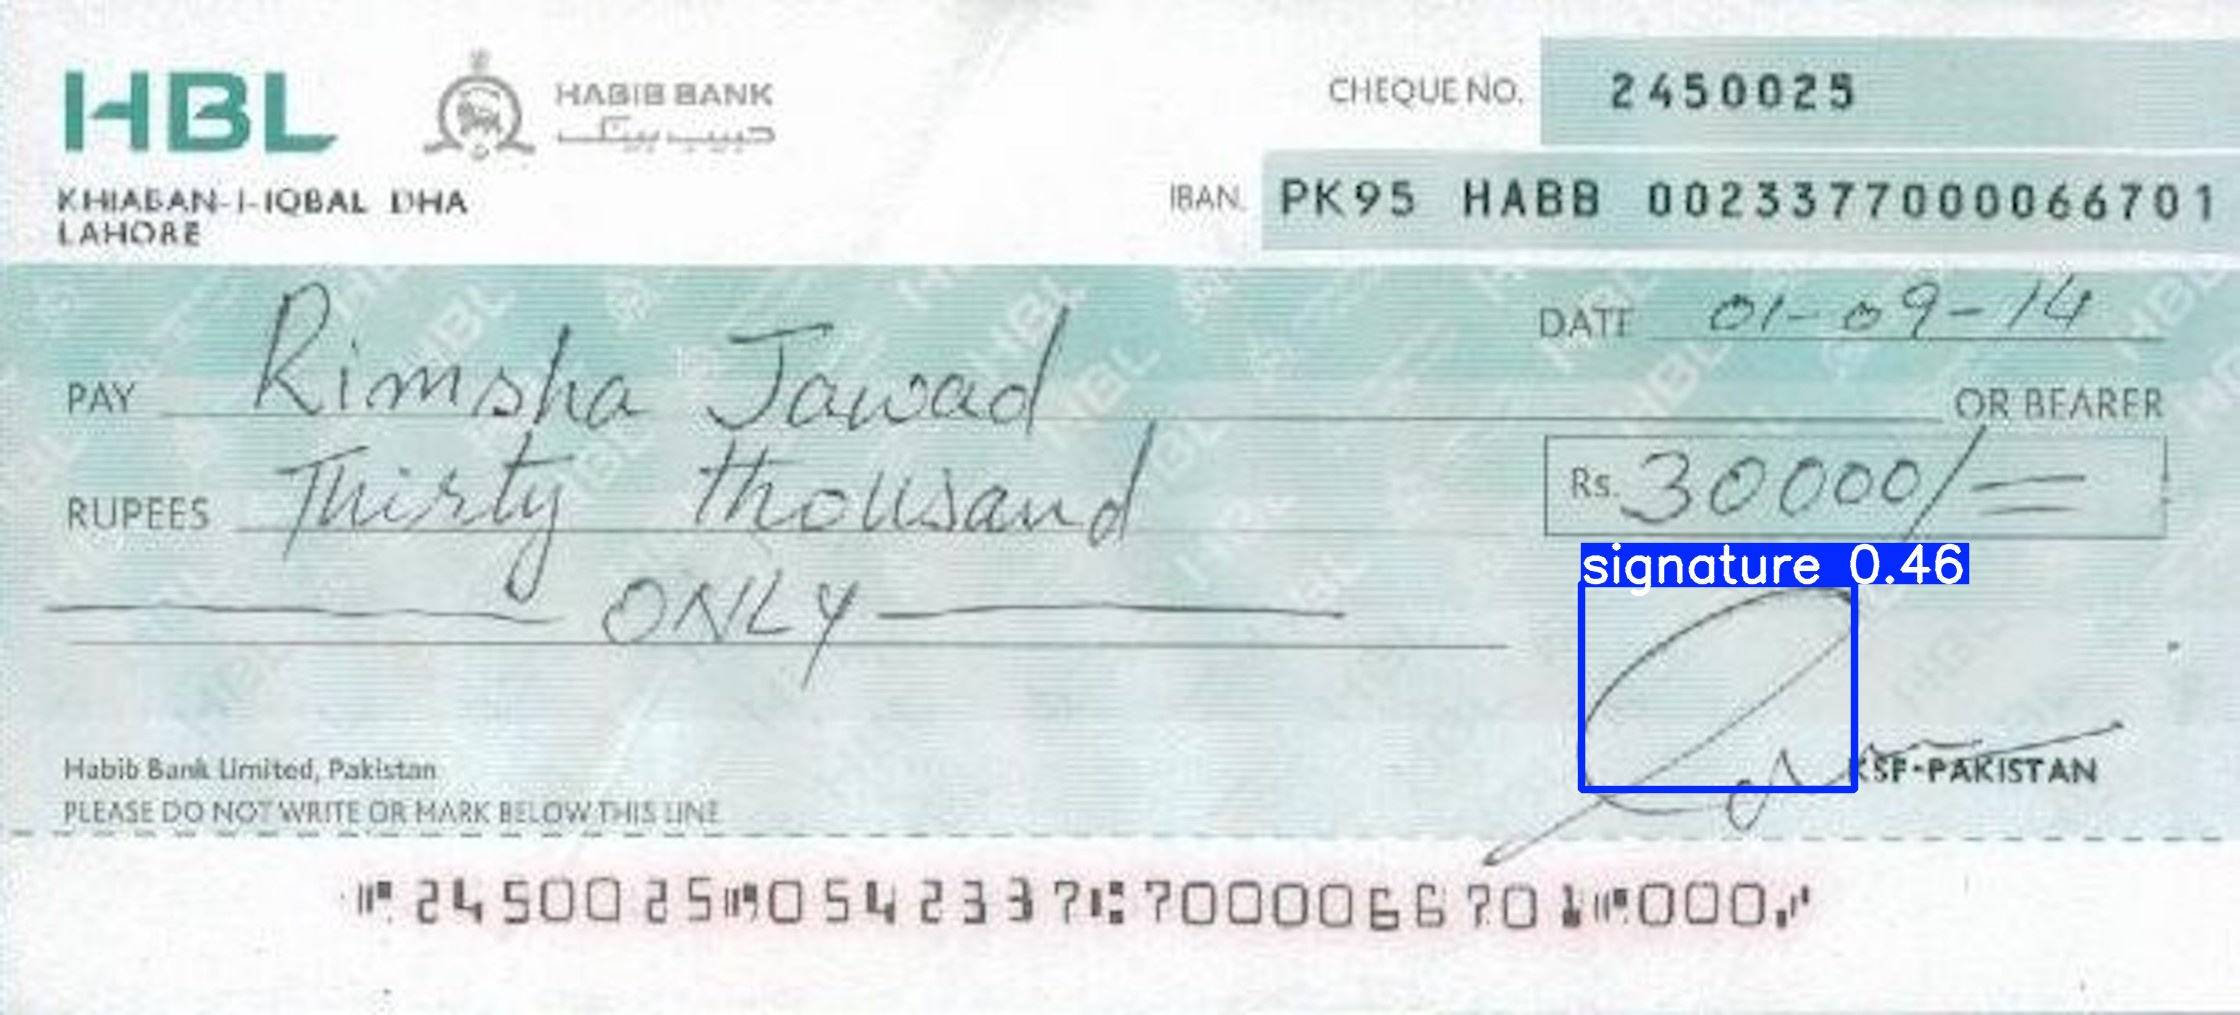

Ảnh dự đoán: /kaggle/working/predictions_visualization/yolov10l_viz_predictions/X_033.jpg


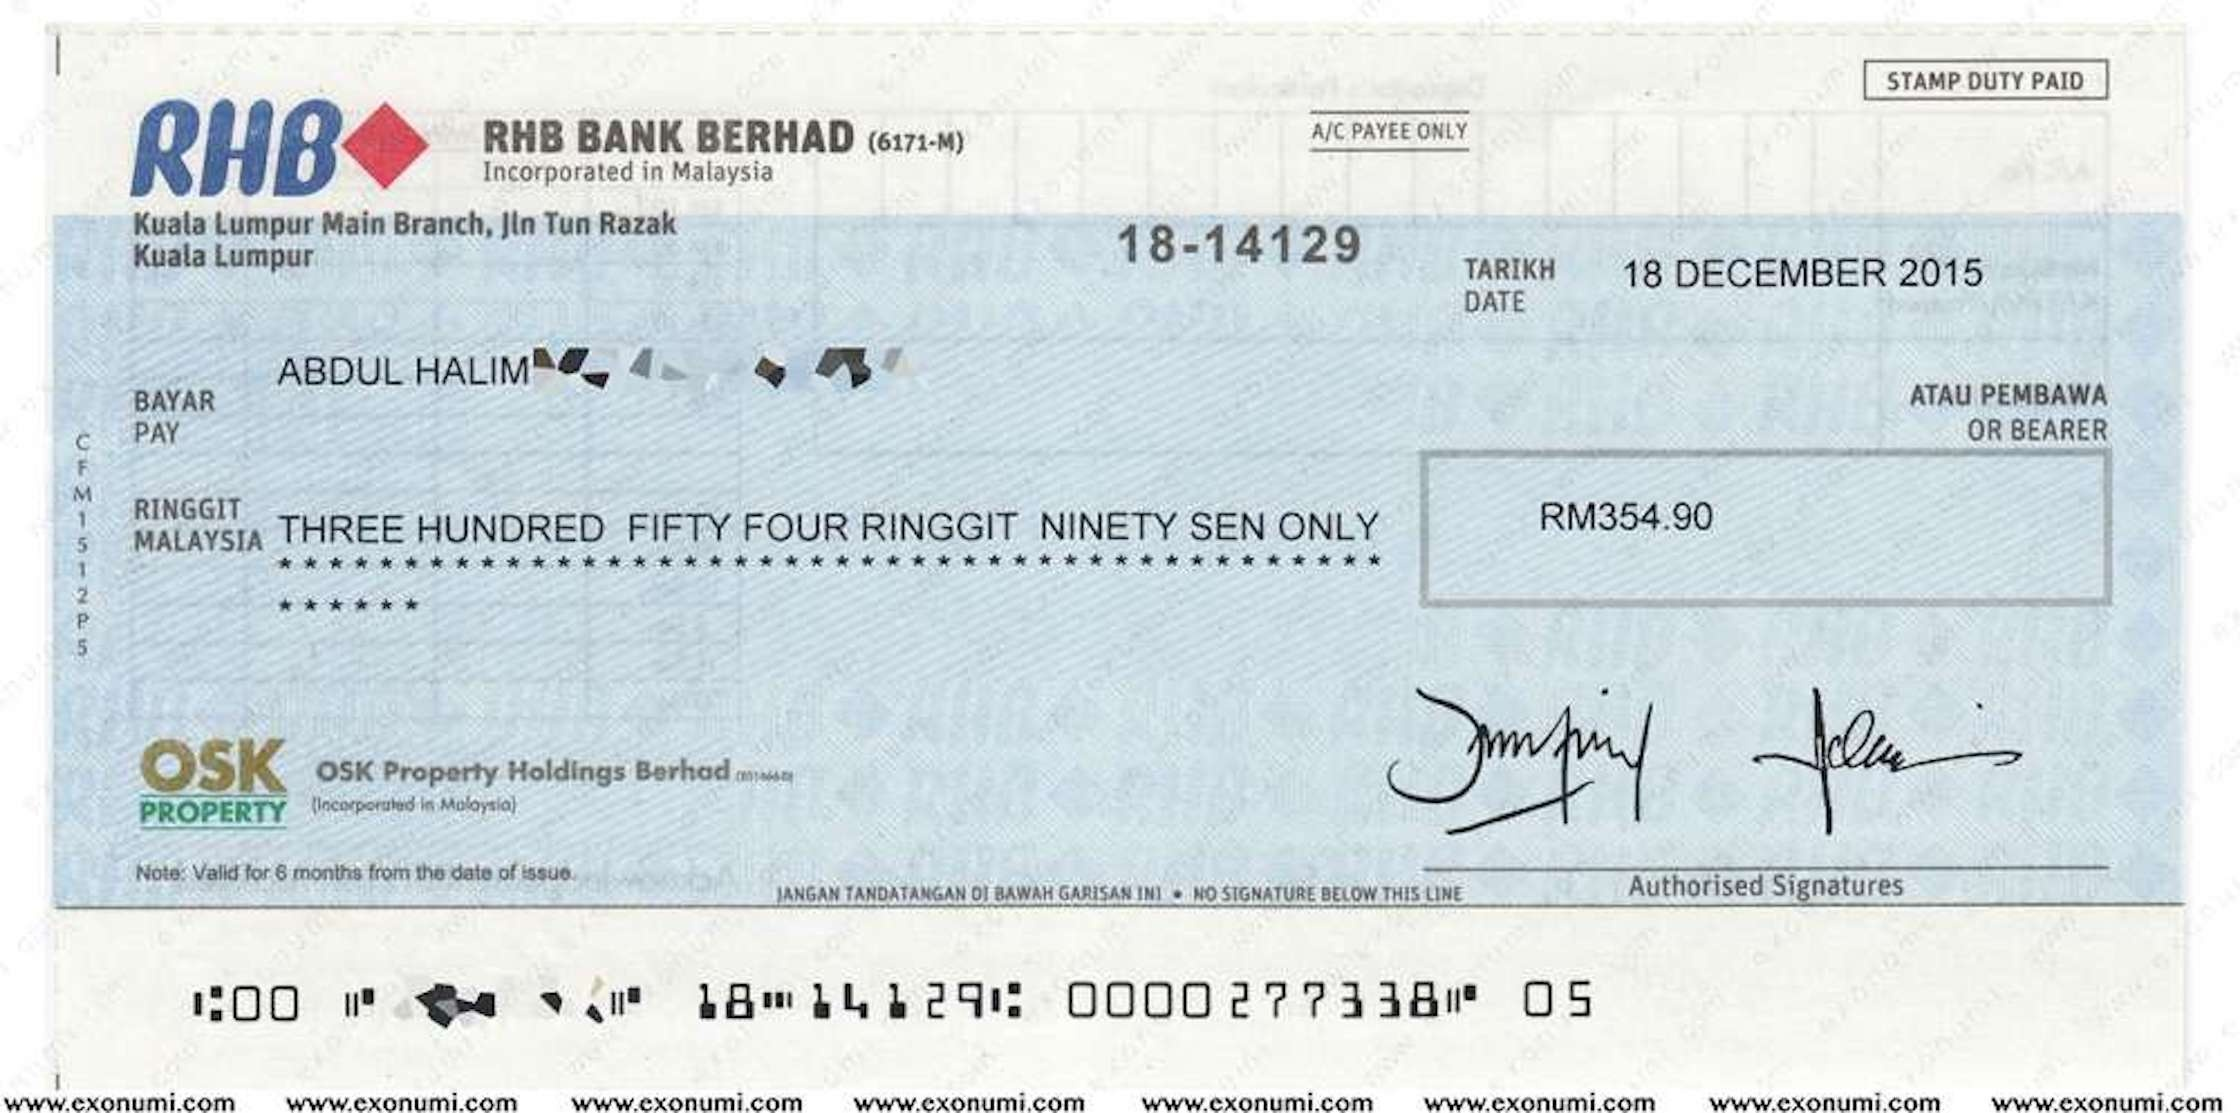

Ảnh dự đoán: /kaggle/working/predictions_visualization/yolov10l_viz_predictions/X_102.jpg


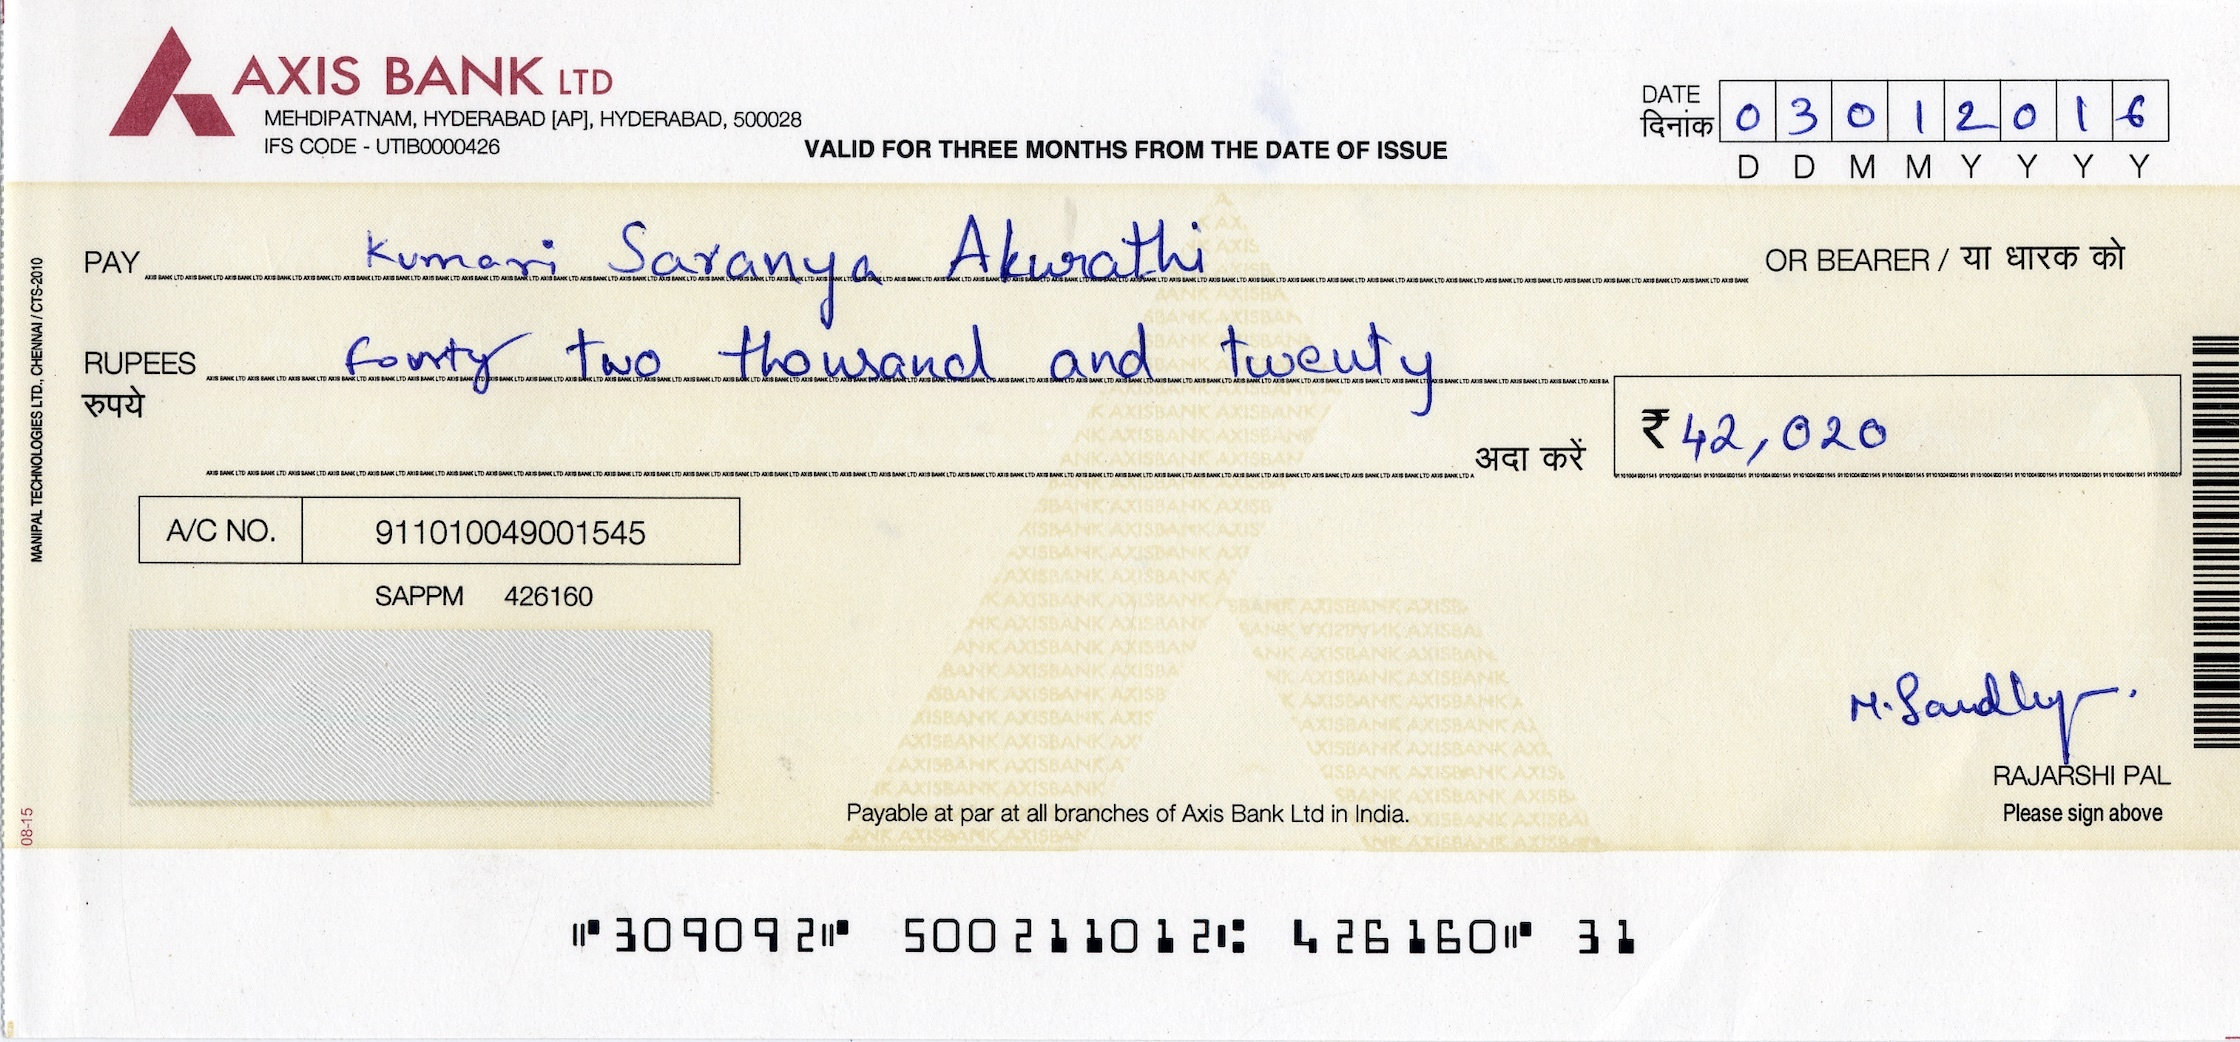

Ảnh dự đoán: /kaggle/working/predictions_visualization/yolov10l_viz_predictions/X_115.jpg


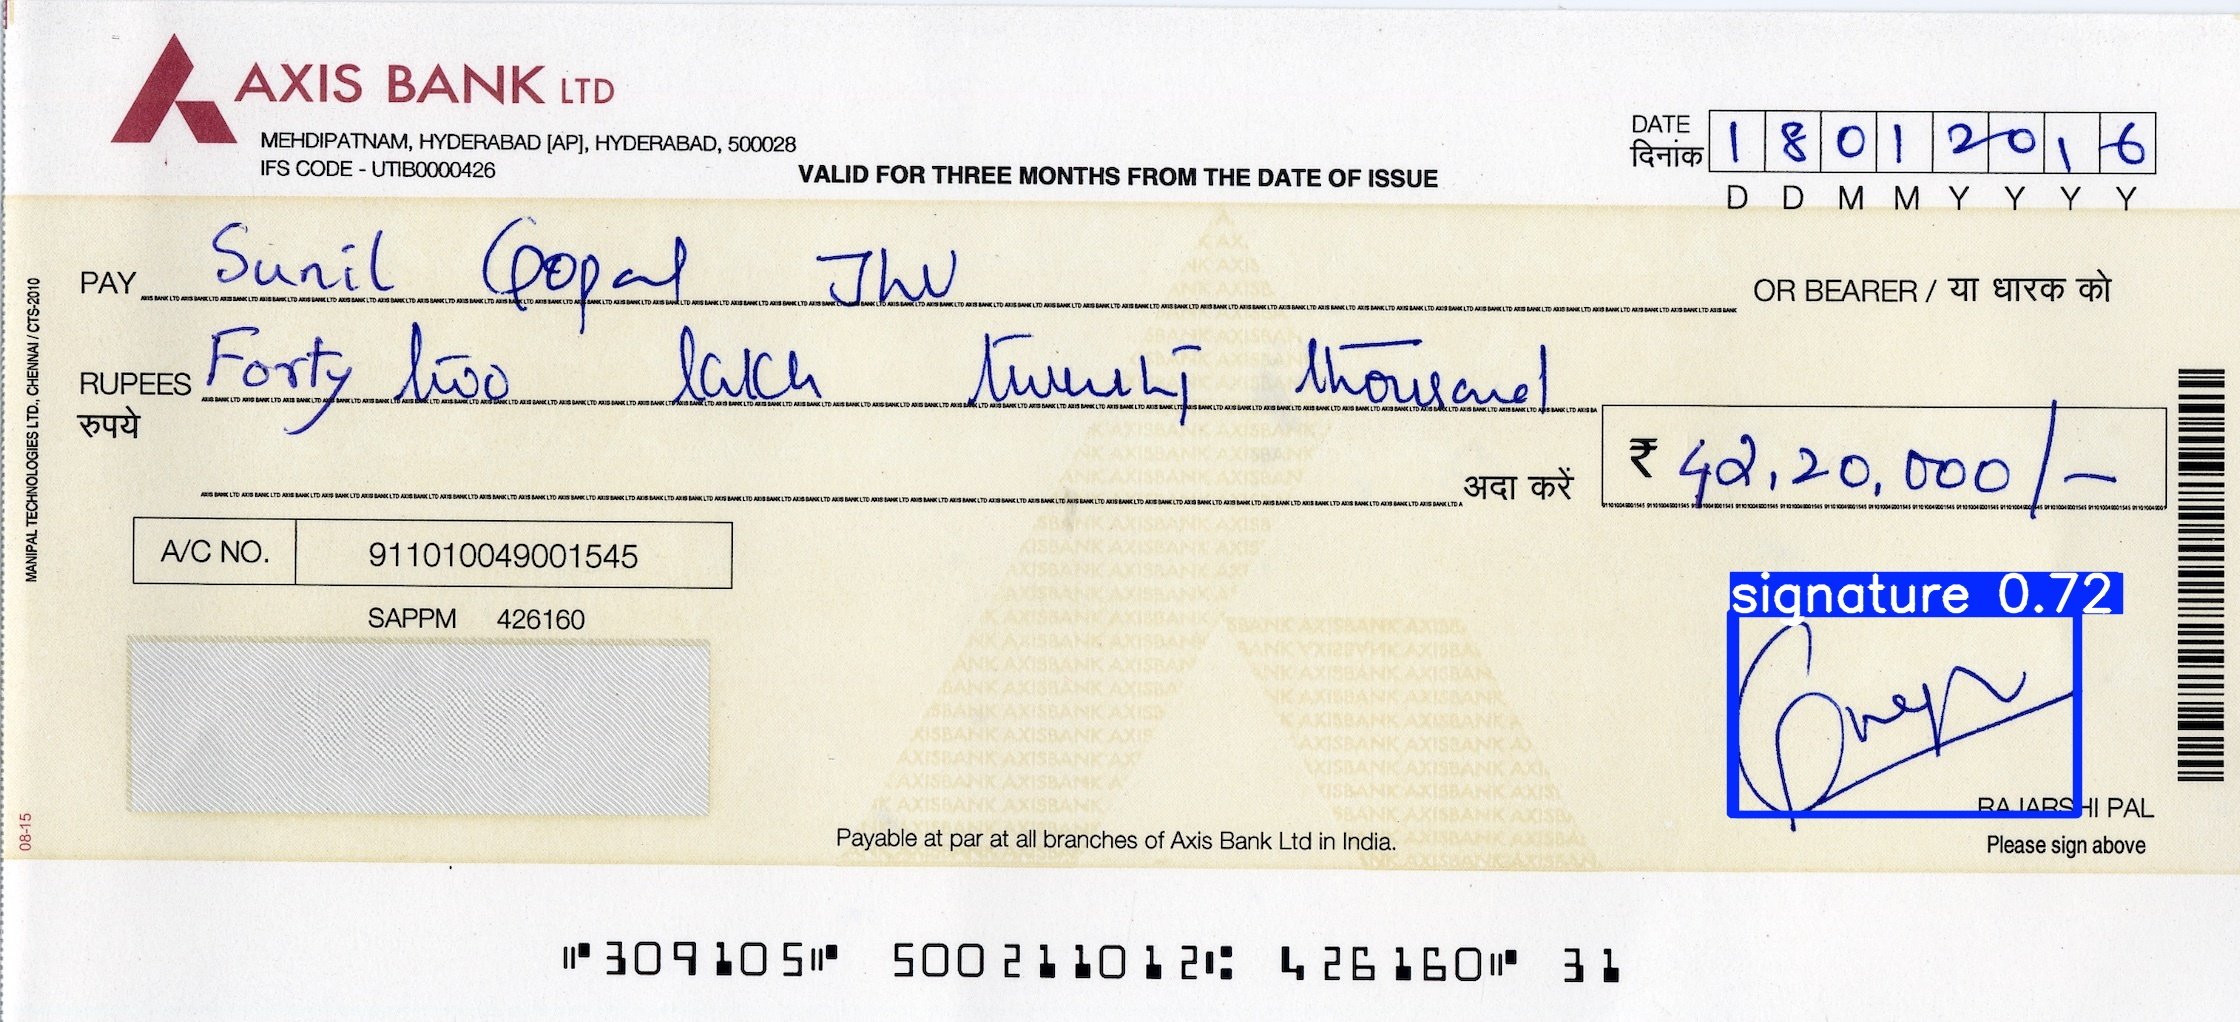


🏁 Script đã chạy xong toàn bộ! 🏁


In [ ]:
run_visualization_prediction = True  # Set to False if you don't want to run this section

# --- Determine the best model to use for visualization ---
best_model_for_viz_path = ""
if 'training_results' in locals() and training_results and hasattr(training_results, 'save_dir'):
    potential_model_path_viz = os.path.join(training_results.save_dir, 'weights/best.pt')
    if os.path.exists(potential_model_path_viz):
        best_model_for_viz_path = potential_model_path_viz
        print(f"Using 'best.pt' model from the current training for visualization: {best_model_for_viz_path}")

if not best_model_for_viz_path:  # If not found from training_results (e.g., running notebook only for prediction)
    if 'PROJECT_SAVE_NAME' in locals() and 'RUN_SAVE_NAME' in locals() and 'BASE_WORKING_DIR' in locals():
        potential_model_path_viz = os.path.join(BASE_WORKING_DIR, PROJECT_SAVE_NAME, RUN_SAVE_NAME, 'weights/best.pt')
        if os.path.exists(potential_model_path_viz):
            best_model_for_viz_path = potential_model_path_viz
            print(f"Using 'best.pt' model found at saved path for visualization: {best_model_for_viz_path}")
        else:
            print(f"Could not find 'best.pt' model at expected path: '{potential_model_path_viz}'.")
            run_visualization_prediction = False
    else:
        print("Required variables (PROJECT_SAVE_NAME, etc.) to locate saved model are not defined.")
        run_visualization_prediction = False

if not best_model_for_viz_path and run_visualization_prediction:  # Double-check
    print("Could not identify 'best.pt' model for visualization. Skipping.")
    run_visualization_prediction = False

# --- Select image source for visualization ---
source_images_for_visualization = []
if run_visualization_prediction:
    # Prioritize selecting a few random images from the validation set if available
    if val_images_list:
        print(f"Selecting sample images from validation set ({VAL_IMAGES_PATH}) for visualization.")
        # val_images_list contains paths to images in _temp, need to use VAL_IMAGES_PATH
        actual_val_image_files = glob.glob(os.path.join(VAL_IMAGES_PATH, '*.*'))
        if actual_val_image_files:
             source_images_for_visualization = random.sample(actual_val_image_files, min(len(actual_val_image_files), 5))  # Max 5 images
    # If no validation set, try using training set
    elif train_images_list:
        print(f"No validation set. Selecting sample images from training set ({TRAIN_IMAGES_PATH}) for visualization.")
        actual_train_image_files = glob.glob(os.path.join(TRAIN_IMAGES_PATH, '*.*'))
        if actual_train_image_files:
            source_images_for_visualization = random.sample(actual_train_image_files, min(len(actual_train_image_files), 5))
    # If you want to use ORIGINAL_TEST_IMAGES_DIR (images merged into train if MERGE_TEST_SET_INTO_TRAINING=True)
    # elif os.path.isdir(ORIGINAL_TEST_IMAGES_DIR) and os.listdir(ORIGINAL_TEST_IMAGES_DIR):
    #     print(f"Selecting sample images from ORIGINAL_TEST_IMAGES_DIR ('{ORIGINAL_TEST_IMAGES_DIR}') for visualization.")
    #     all_orig_test_imgs = glob.glob(os.path.join(ORIGINAL_TEST_IMAGES_DIR, '[Xx]_*.*'))
    #     if all_orig_test_imgs:
    #         source_images_for_visualization = random.sample(all_orig_test_imgs, min(len(all_orig_test_imgs), 5))
            
    if not source_images_for_visualization:
        print("No suitable images found for visualization. Skipping this section.")
        run_visualization_prediction = False

if run_visualization_prediction:
    print(f"\nStarting visualization of predictions on {len(source_images_for_visualization)} sample images...")
    
    try:
        # Ensure required configuration variables exist (from training cell)
        current_input_img_size_viz = INPUT_IMG_SIZE if 'INPUT_IMG_SIZE' in locals() else 640
        current_model_name_viz = os.path.splitext(CHOSEN_MODEL_NAME)[0] if 'CHOSEN_MODEL_NAME' in locals() else "yolov10_model"
            
        visualization_model = YOLO(best_model_for_viz_path)

        # Subdirectory name for this visualization run
        visualization_run_name = f"{current_model_name_viz}_viz_predictions"
        
        # Perform predictions on the selected image list
        # Source can be a list of image paths
        visualization_model.predict(
            source=source_images_for_visualization, 
            imgsz=current_input_img_size_viz,
            conf=0.35,      # Confidence threshold (can be increased for fewer boxes)
            iou=0.5,        # IoU threshold
            save=True,      # Save images with drawn bounding boxes
            project=VISUALIZATION_PREDICTIONS_SAVE_DIR, 
            name=visualization_run_name,     
            exist_ok=True,
            show_labels=True,  # Show class labels
            show_conf=True     # Show confidence scores
        )
        
        actual_visualization_output_dir = os.path.join(VISUALIZATION_PREDICTIONS_SAVE_DIR, visualization_run_name)
        print(f"Visualization completed. Results (images with bounding boxes) saved at: {actual_visualization_output_dir}")

        # Display predicted images (located in the subdirectory of actual_visualization_output_dir)
        predicted_viz_image_files = []
        # Images are typically saved directly in the subdirectory (no further subdirectories when source is a list)
        for ext in ['*.jpg', '*.jpeg', '*.png']:
            predicted_viz_image_files.extend(glob.glob(os.path.join(actual_visualization_output_dir, ext)))
        
        # Filter out non-image files if any (e.g., labels.jpg if generated by YOLO)
        predicted_viz_image_files = [f for f in predicted_viz_image_files if not os.path.basename(f).startswith('labels')]

        if predicted_viz_image_files:
            print(f"\nDisplaying visualized images ({len(predicted_viz_image_files)} images):")
            for img_file_viz in sorted(predicted_viz_image_files):  # Sort for easier tracking
                print(f"Predicted image: {img_file_viz}")
                display(IPImageDisplay(filename=img_file_viz, width=700)) 
        else:
            print(f"No result images found in '{actual_visualization_output_dir}' to display.")
            
    except NameError as ne_viz:
        print(f"NameError occurred while attempting visualization: {ne_viz}")
        print("Ensure required variables (e.g., 'YOLO', 'INPUT_IMG_SIZE', 'CHOSEN_MODEL_NAME') are defined.")
    except Exception as e_viz:
        print(f"An error occurred during visualization of predictions: {e_viz}")
        import traceback
        traceback.print_exc()
else:
    print("\nSkipping visualization of predictions due to unmet conditions or being disabled.")

print("\n🏁 Script execution completed! 🏁")

In [ ]:
visualization_model.predict('/kaggle/input/bank-checks-signatures-segmentation-dataset/TestSet/X/X_041.jpeg')[0].show()

In [27]:
import kagglehub

kagglehub.login()

# Replace with path to directory containing model files.
LOCAL_MODEL_DIR = '/kaggle/working/Signature_YOLOv10_Detection_Kaggle/yolov10s_epochs100_batch16/weights/best.pt'

MODEL_SLUG = 'Yolo-with-signatures' # Replace with model slug.

# Learn more about naming model variations at
# https://www.kaggle.com/docs/models#name-model.
VARIATION_SLUG = 'default' # Replace with variation slug.

kagglehub.model_upload(
  handle = f"nguyenthien3001/{MODEL_SLUG}/pyTorch/{VARIATION_SLUG}",
  local_model_dir = LOCAL_MODEL_DIR,
  version_notes = 'Update 2025-05-25')

Uploading Model https://www.kaggle.com/models/nguyenthien3001/Yolo-with-signatures/pyTorch/default ...
Starting upload for file /kaggle/working/Signature_YOLOv10_Detection_Kaggle/yolov10l_epochs100_batch16/weights/best.pt


Uploading: 100%|██████████| 52.1M/52.1M [00:01<00:00, 42.7MB/s]

Upload successful: /kaggle/working/Signature_YOLOv10_Detection_Kaggle/yolov10l_epochs100_batch16/weights/best.pt (50MB)


Your model instance version has been created.
Files are being processed...
See at: https://www.kaggle.com/models/nguyenthien3001/Yolo-with-signatures/pyTorch/default


Đang nạp model từ: /kaggle/working/Signature_YOLOv10_Detection_Kaggle/yolov10s_epochs100_batch16/weights/best.pt
Model được nạp trên thiết bị: cuda
Đang thực hiện dự đoán trên ảnh: /kaggle/input/bank-checks-signatures-segmentation-dataset/TestSet/X/X_018.jpeg
Tổng số đối tượng phát hiện được: 4
  Phát hiện chữ ký với confidence: 0.5280, tọa độ: [1891, 649, 2089, 708]
  Phát hiện chữ ký với confidence: 0.5205, tọa độ: [1888, 651, 2093, 715]
  Phát hiện chữ ký với confidence: 0.3735, tọa độ: [1666, 654, 1865, 690]
  Phát hiện chữ ký với confidence: 0.2644, tọa độ: [1662, 652, 1781, 688]

Chữ ký có confidence cao nhất: 0.5280
Tọa độ (x1, y1, x2, y2): (1891, 649, 2089, 708)
Đã lưu chữ ký có confidence cao nhất tại: /kaggle/working/cropped_signatures/X_018_signature_cropped.png
Ảnh chữ ký được cắt:


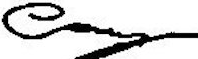

In [ ]:
from ultralytics import YOLO
from PIL import Image
import os
import torch 

def crop_highest_confidence_signature(image_path, model_path, output_crop_path, signature_class_id=0):
    """
    Detect signatures in an image, select the signature with the highest confidence,
    crop it, and save it.

    Args:
        image_path (str): Path to the input image.
        model_path (str): Path to the trained YOLO model file (e.g., 'best.pt').
        output_crop_path (str): Path to save the cropped signature image.
        signature_class_id (int): ID of the 'signature' class (default is 0).
    """
    try:
        # 1. Load the YOLO model
        print(f"Loading model from: {model_path}")
        model = YOLO(model_path)

        # Check device and move model if necessary (e.g., if model was trained on GPU)
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model.to(device)
        print(f"Model loaded on device: {device}")

        # 2. Perform prediction
        print(f"Performing prediction on image: {image_path}")
        # verbose=False to reduce log output, device=device to ensure running on the selected device
        results = model.predict(source=image_path, verbose=False, device=device)

        if not results or not results[0].boxes:
            print("No objects detected in the image.")
            return

        highest_confidence = 0.0
        best_box_coords = None
        found_signature = False

        # results[0].boxes contains information about bounding boxes for the first (and only) image
        # Important attributes: .xyxy (coordinates), .conf (confidence), .cls (class ID)
        
        # Move boxes to CPU for processing if on GPU
        boxes_data = results[0].boxes.data.cpu().numpy()  # Convert tensor to numpy array on CPU

        print(f"Total number of detected objects: {len(boxes_data)}")

        for box_data in boxes_data:
            # box_data is a row, e.g., [x1, y1, x2, y2, confidence, class_id]
            x1, y1, x2, y2, conf, cls_id = box_data
            
            # 3. Filter by class_id and find the highest confidence
            if int(cls_id) == signature_class_id:
                found_signature = True
                print(f"  Detected signature with confidence: {conf:.4f}, coordinates: [{int(x1)}, {int(y1)}, {int(x2)}, {int(y2)}]")
                if conf > highest_confidence:
                    highest_confidence = conf
                    best_box_coords = (int(x1), int(y1), int(x2), int(y2))  # Store as tuple (int)

        if not found_signature:
            print(f"No objects found belonging to the signature class (ID: {signature_class_id}).")
            return
            
        if best_box_coords:
            print(f"\nSignature with highest confidence: {highest_confidence:.4f}")
            print(f"Coordinates (x1, y1, x2, y2): {best_box_coords}")

            # 4. Crop the signature from the original image
            original_image = Image.open(image_path)
            cropped_signature = original_image.crop(best_box_coords)

            # 5. Save the cropped signature image
            # Ensure output directory exists
            os.makedirs(os.path.dirname(output_crop_path), exist_ok=True)
            cropped_signature.save(output_crop_path)
            print(f"Saved highest-confidence signature at: {output_crop_path}")
            
            # Display the cropped image (optional, if running in an environment that supports display)
            try:
                from IPython.display import display
                print("Cropped signature image:")
                display(cropped_signature)
            except ImportError:
                pass  # Skip if IPython.display is not available

        else:
            # This case should not occur if found_signature is True, but included for safety
            print("No signatures found (after confidence check).")

    except Exception as e:
        print(f"An error occurred: {e}")
        import traceback
        traceback.print_exc()

# --- EXAMPLE USAGE ---
if __name__ == '__main__':
    # --- UPDATE THESE PATHS AS NEEDED ---
    
    # Assume the 'best.pt' model is in the results directory from the most recent training
    # You need to provide the correct path based on PROJECT_SAVE_NAME and RUN_SAVE_NAME from the training script
    # Example:
    # PROJECT_SAVE_NAME_FROM_TRAIN = 'Signature_YOLOv10_Detection_Kaggle'
    # RUN_SAVE_NAME_FROM_TRAIN = 'yolov10s_epochs100_batch16'  # Specific run name
    # trained_model_path = f'/kaggle/working/{PROJECT_SAVE_NAME_FROM_TRAIN}/{RUN_SAVE_NAME_FROM_TRAIN}/weights/best.pt'
    
    # Or a fixed path if known
    trained_model_path = '/kaggle/working/Signature_YOLOv10_Detection_Kaggle/yolov10s_epochs100_batch16/weights/best.pt'  # ⚠️ UPDATE THIS PATH

    # Path to the image you want to process
    # Example using an image from TestSet (if TestSet was merged into train, these are "seen" images)
    # Or a completely new image
    input_image_file = '/kaggle/input/bank-checks-signatures-segmentation-dataset/TestSet/X/X_018.jpeg'  # ⚠️ UPDATE THIS PATH

    # Path to save the cropped signature
    output_directory_for_crops = '/kaggle/working/cropped_signatures/'
    # Create output filename based on input filename
    base_img_name = os.path.splitext(os.path.basename(input_image_file))[0]
    cropped_signature_file = os.path.join(output_directory_for_crops, f"{base_img_name}_signature_cropped.png")

    # Check if model and image exist
    if not os.path.exists(trained_model_path):
        print(f"ERROR: Model file not found at: {trained_model_path}")
        print("Please check the `trained_model_path`.")
    elif not os.path.exists(input_image_file):
        print(f"ERROR: Input image file not found at: {input_image_file}")
        print("Please check the `input_image_file`.")
    else:
        # Call the function to process
        crop_highest_confidence_signature(
            image_path=input_image_file,
            model_path=trained_model_path,
            output_crop_path=cropped_signature_file,
            signature_class_id=0  # Assume 'signature' class ID is 0
        )